# **Librerías**

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 808.2 kB/s eta 0:00:00


In [ ]:
# Importación de frameworks y librerías
import numpy as np
import pandas as pd
import random

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y transformación de datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
import category_encoders as ce
from sklearn.preprocessing import label_binarize

# Modelado y evaluación
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost as xgb

# **Funciones**

In [ ]:
# Ver valores únicos en columnas categóricas
def see_unique_values():
  for i in df.columns:
    if df[i].dtype == 'object':
      print(f"{i}: {df[i].unique()}")
      print("")

#Ver columnas con alta y baja cardinalidad (cantidad de valores unicos), el límite fue definido en 5
def determinar_cardinalidad(df):
  B_C=[]
  A_C=[]
  for columna in df.columns:
    if df[columna].dtype=='object':
      if len(df[columna].unique()) >5: #Si en la columna hay mas de 5 valores unicos, se considera de alta cardinalidad
        A_C.append(columna)
      else:
        B_C.append(columna)
  return A_C, B_C

#Creación de dummies
def create_dummies(df, columnas):
  for columna in columnas:
    nombre_columna = ''.join([palabra[0] for palabra in columna.split('_')])#Se crea el prefijo que tendran las columnas dummies, que sera las iniciales en mayuscula de cada palabra en el nombre de la columna original
    df_dummies=pd.get_dummies(df[columna],prefix=nombre_columna.upper())
    df=pd.concat([df,df_dummies],axis=1)
  return df

#Eliminar columnas categóricas
def eliminar_columnas_cat(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df.drop(col, axis = 1 , inplace=True)

#Ver correlación
def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(15,10))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)


# Categorizar peso
def map_weight_category(row):
    if abs(row['Bajo peso en adultos de 19 a 59 años']) == 1:
        return 0
    elif abs(row['Peso Normal en adultos de 19 a 59 años']) == 1:
        return 1
    elif abs(row['Sobrepeso en adultos de 19 a 59 años ']) == 1:
        return 2
    elif abs(row['Obesidad en adultos de 19 a 59 años ']) == 1:
        return 3
    else:
        return -1

def oversample_category(df, category, n_samples):
    df_category = df[df['weight_category'] == category]
    df_oversampled = resample(df_category, replace=True, n_samples=n_samples, random_state=42)
    return df_oversampled


# **Preparación del dataset**

## **Carga del dataset**

In [ ]:
pd.set_option('display.max_rows', None) #ajuste de opciones de visualizacion en pandas
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) # Configurar Pandas para mostrar todas las columnas

In [ ]:
df_original = pd.read_csv("/content/1_BDD_ENS2018_f1_personas_featureEngineering.csv", encoding='ISO-8859-1')
df_original.head(5)

<ipython-input-5-c957a28dbbbb>:1: DtypeWarning: Columns (44,119,123,124,127,128,130,132,173,188) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv("/content/1_BDD_ENS2018_f1_personas_featureEngineering.csv", encoding='ISO-8859-1')


Área  Provincia  Identificador de upm  Identificador de vivienda  Identificador del hogar  Identificador de la persona  Cód. Persona    Sexo  Años cumplidos  Meses cumplidos  Fecha de nacimiento _Día  Fecha de nacimiento _Meses  Fecha de nacimiento _Año Parentesco con el jefe (a) de hogar Está afiliado o cubierto _Alt1 Está afiliado o cubierto _Alt2 Cómo se Identifica, según su cultura y costumbres Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Tiene, carné de discapacidad emitido por el CONADIS o el MSP  Qué porcentaje tiene Fue visitado ,por la Misión Manuela Espejo El padre vive en este hogar  Cód Persona ,Padre La madre vive en este hogar  Cód Persona, Madre Cuál es su Estado Civil ó Conyugal Asiste, actualmente a clases Jornada a la que asisten a clases Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Por los estudios realizados obtuvo algún título superior Qué título obtuvo Tiene teléfono celular activado  Cuántos  Cód. Per. Inf.   Qué hizo la semana pasada Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar  Aunque no haya trabajado la semana pasada, tiene algún trabajo o negocio al cual seguro va a volver Razón por qué no trabajó la semana pasada Durante las últimas cuatro semanas, hizo alguna gestión para buscar trabajo  Tiempo que busca trabajo Razón por qué no buscó trabajo Está disponible para trabajar INACTIVIDAD   Uso INEC _COD Rama de Actividad  Uso INEC _COD Grupo de Ocupación En el lugar indicado, trabaja o trabajó como      Sitios o lugares donde trabaja Cuántos trabajos tuvo, en la semana pasada  Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto Retiró de su negocio o tomó de lo que produce o vende, bienes, servicios o productos para el consumo del hogar  Monto  Cuánto gastó para el funcionamiento de su negocio _Monto  Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto  Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Monto.1  Ingreso monetario segunda ocupación _Monto En su otra ocupación (es), recibió por su trabajo pago en especies o retiró del negocio o producción bienes o productos para el consumo del hogar  Monto.2 Recibió ingresos por concepto de intereses por: cuenta de ahorros, corrientes, préstamos a terceros, hipotecas; bonos por acciones; arriendo de casas, edificios, terrenos, maquinaria, etc.  Monto.3 Recibió  ingresos por concepto de pensión por: jubilación, orfandad, viudez, invalidez, enfermedad, divorcio, cesantía, etc.  Monto.4 Recibió dinero o especies por regalos o donaciones de personas o instituciones que vivan dentro del país  Monto.5 Recibió dinero o especies enviado por parte de familiares o amigos que vivan en el exterior  Monto.6 Recibe el Bono de desarrollo humano  Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto  De Cuántos meses recibió el Bono de desarrollo humano Recibe el Bono por el cuidado brindado a una persona discapacitada del hogar  Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto  De Cuántos meses recibió el Bono de discapacidad Joaquín Gallegos Lara Principalmente donde acude o acudiría para tratar sus problemas de salud En los últimos 30 días tuvo alguna enfermedad, accidente, quemadura, dolor de muela, oído o algún otro malestar aunque éste haya sido pasajero Enfermedad, malestar o accidente más grave que tuvo en los últimos 30 días Tiemp

In [ ]:
list(df_original.columns)

['Área',
 'Provincia',
 'Identificador de upm',
 'Identificador de vivienda',
 'Identificador del hogar',
 'Identificador de la persona',
 'Cód. Persona',
 'Sexo',
 'Años cumplidos',
 'Meses cumplidos',
 'Fecha de nacimiento _Día',
 'Fecha de nacimiento _Meses',
 'Fecha de nacimiento _Año',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 'Cómo se Identifica, según su cultura y costumbres',
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 'Tiene, carné de discapacidad emitido por el CONADIS o el MSP',
 'Qué porcentaje tiene',
 'Fue visitado ,por la Misión Manuela Espejo',
 'El padre vive en este hogar',
 'Cód Persona ,Padre',
 'La madre viv

In [ ]:
#Lista de las columnas

['Área',
 'Provincia',
 #'Identificador de upm',
 #'Identificador de vivienda', #PUEDA QUE SI LA NECESITEMOS
 #'Identificador del hogar',
 #'Identificador de la persona',
 #'Cód. Persona',
 'Sexo',
 'Años cumplidos',
 #'Meses cumplidos',
 #'Fecha de nacimiento _Día',
 #'Fecha de nacimiento _Meses',
 #'Fecha de nacimiento _Año',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 #'Cómo se Identifica, según su cultura y costumbres', #hay una columna con identificacion etnica mas resumida
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 #'Tiene, carné de discapacidad emitido por el CONADIS o el MSP', #se obvia esta pregunta porque tener carnet de discapacidad, en Ecuador, no es sinonimo de realmente tener discapacidad
 #'Qué porcentaje tiene',
 #'Fue visitado ,por la Misión Manuela Espejo',
 'El padre vive en este hogar',
 #'Cód Persona ,Padre',
 'La madre vive en este hogar',
 #'Cód Persona, Madre',
 'Cuál es su Estado Civil ó Conyugal',
 'Asiste, actualmente a clases',
 'Jornada a la que asisten a clases',
 'Nivel de instrucción más alto que aprobó _Nivel',
 'Año de instrucción más alto que aprobó _Año',
 'Sabe leer y escribir',
 'Por los estudios realizados obtuvo algún título superior',
 #'Qué título obtuvo', #podemos obviar esta porque hay un monton de opciones y porque ya tenemos la columna de tipo de instruccion
 'Tiene teléfono celular activado',
 'Cuántos',
 #'Cód. Per. Inf.',
 'Qué hizo la semana pasada',
 'Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ',
 'Aunque no haya trabajado la semana pasada, tiene algún trabajo o negocio al cual seguro va a volver',
 'Razón por qué no trabajó la semana pasada',#me parece interesante esta columna
 'Durante las últimas cuatro semanas, hizo alguna gestión para buscar trabajo',
 'Tiempo que busca trabajo',
 'Razón por qué no buscó trabajo',
 'Está disponible para trabajar',
 'INACTIVIDAD ',
 #'Uso INEC _COD Rama de Actividad', CREO Q ESTA NO ES RELEVANTE
 #'Uso INEC _COD Grupo de Ocupación',
 'En el lugar indicado, trabaja o trabajó como',
 'Sitios o lugares donde trabaja',
 'Cuántos trabajos tuvo, en la semana pasada',
 'Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto',#esto se suma con los otros montos
 'Retiró de su negocio o tomó de lo que produce o vende, bienes, servicios o productos para el consumo del hogar',
 'Monto',
 'Cuánto gastó para el funcionamiento de su negocio _Monto',
 'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto',#sumar
 'Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto',#restar esto del total de los montos
 'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
 'Monto.1',#sumar
 'Ingreso monetario segunda ocupación _Monto',
 'En su otra ocupación (es), recibió por su trabajo pago en especies o retiró del negocio o producción bienes o productos para el consumo del hogar',
 'Monto.2',
 'Recibió ingresos por concepto de intereses por: cuenta de ahorros, corrientes, préstamos a terceros, hipotecas; bonos por acciones; arriendo de casas, edificios, terrenos, maquinaria, etc.',
 'Monto.3',
 'Recibió  ingresos por concepto de pensión por: jubilación, orfandad, viudez, invalidez, enfermedad, divorcio, cesantía, etc.',
 'Monto.4',
 'Recibió dinero o especies por regalos o donaciones de personas o instituciones que vivan dentro del país',
 'Monto.5',
 'Recibió dinero o especies enviado por parte de familiares o amigos que vivan en el exterior',
 'Monto.6',
 'Recibe el Bono de desarrollo humano',
 'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto',
 'De Cuántos meses recibió el Bono de desarrollo humano',
 'Recibe el Bono por el cuidado brindado a una persona discapacitada del hogar',
 'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto',
 'De Cuántos meses recibió el Bono de discapacidad Joaquín Gallegos Lara',
 'Principalmente donde acude o acudiría para tratar sus problemas de salud',
 'En los últimos 30 días tuvo alguna enfermedad, accidente, quemadura, dolor de muela, oído o algún otro malestar aunque éste haya sido pasajero',
 'Enfermedad, malestar o accidente más grave que tuvo en los últimos 30 días',
 'Tiempo que ocurrió el problema de salud por primera vez',
 'Cuántos, (Días, meses, años)',
 'En los últimos 30 días, cuántos días ha estado con el problemas de salud,',
 'Qué hizo como primera acción para solucionar el problema de salud',
 'Motivo por el que no hizo nada para resolver el  problema de salud',
 'A dónde acudió o quién le atendió por el  problema de salud',
 'Motivo principal por el que eligió ir a ese establecimiento o proveedor de salud',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _DÍAS',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _HORAS',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _MINUTOS',
 'Gastó en transporte para llegar al establecimiento o proveedor de servicios de salud ',
 'Tiempo que esperó para que le atiendan _DÍAS',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que espero para que le atiendan en el establecimiento o proveedor de servicios de salud _minutos',
 'Quién le atendió por su problema de salud, cuando llegó al establecimiento o proveedor de salud',
 'Qué atención o servicio de salud recibió principalmente en el establecimiento o proveedor de servicios de salud',
 'Por el problema de salud que tuvo gastó en consultas,  medicamentos, exámenes de laboratorio, radiografías, etc., en el establecimiento o proveedor de servicio de salud al que acudió',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _persona',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _Seguro/otro',
 'Compró medicamentos fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó',
 'Tuvo que realizarse exámenes de laboratorio fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó.1',#sumar
 'Realizó algún otro pago por radiografía, tomografía, mamografía, endoscopía, etc. fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó.2',#sumar
 'Quién le atendió la última vez, por  su problema de salud en la casa',
 'Cuánto pagó por la atención que recibió en su casa la última vez',
 'Compró medicinas,  preparados u otros medicamentos o remedios o pagó por exámenes, radiografías, etc.',
 'Cuánto pagó.3',#sumar
 'De quién o de dónde obtuvo la información acerca de estos medicamentos',
 'Dónde obtuvo las medicinas, remedios u otros medicamentos que utilizó para curarse',
 'Cuánto pagó por las medicinas, remedios u otros medicamentos que utilizó para curarse',
 'Con la primera acción que hizo, se resolvió o se curó del problema de salud',
 'Qué otra acción hizo',
 'Motivo por el que no  hizo nada para  resolver el problema de salud',
 'Dónde estuvo hospitalizado',
 'Tiempo que  estuvo hospitalizado _DÍAS',
 'Tiempo que  estuvo hospitalizado _HORAS',
 'Tiempo que  estuvo hospitalizado _MINUTOS',
 'Gastó por la hospitalización, dentro del establecimiento o proveedor de servicio de salud',
 'Por el o los gasto(s) que tuvo en hospitalización',
 'Cuánto pagó _Persona',
 'Cuánto pagó _Seguro/otro',
 'Cómo obtuvo el dinero para pagar los gastos de hospitalización',
 'Cuando estuvo hospitalizado, compró medicamentos fuera del establecimiento',
 'Cuánto pagó.4',#sumar
 'Cuando estuvo hospitalizado, se hizo exámenes de laboratorio fuera del establecimiento',
 'Cuánto pagó.5',#sumar
 'Cuando estuvo hospitalizado, se hizo  radiografía, tomografía, mamografía, endoscopía, etc. fuera del establecimiento',
 'Cuánto pagó.6',#sumar
 'Finalmente se resolvió el problema de salud durante los últimos 30 días',
 'Que otra acción hizo principalmente',
 'Cuántas veces más se trató por el problema de salud que tuvo durante los últimos 30 días',
 'Cuánto más gastó en total',#esta puede ser la columna que debemos dejar. Revisar que cuadre
 'Atención de salud preventiva si se hizo chequear _últimos 30 días',
 'A donde acudió para hacerse el chequeo o control de su salud',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _DIAS',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _HORAS',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _MINUTOS',
 'Cuánto gastó en transporte para llegar al establecimiento o proveedor de servicios de salud',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _horas.1',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _minutos',
 'Atención o  servicios de salud que recibió principalmente',
 'Por el control preventivo que tuvo ,gastó en consultas, medicamentos, exámenes de laboratorio, radiografías, etc. en el establecimiento o proveedor de servicio de salud al que acudió',
 'Por el o los gasto en el control preventivo que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _Código',
 'Cuánto Pagó _Persona',
 'Cuánto Pagó _Seguro / Otro',
 'Se realizó exámenes o efectuó otro gasto fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto Pagó',
 'Cuándo tuvo el problema de salud o se estuvo haciendo chequear faltó o dejó de trabajar',
 'Cuántos días faltó ',
 'Ingreso que perdió por no ir a trabajar en esos días',
 'Tuvo alguna enfermedad o accidente por el cual estuvo hospitalizado _últimos 12 meses',
 'Enfermedad , malestar o accidente más graves',
 'Donde estuvo hospitalizado la última vez',
 'Cuántas veces se ha atendido por un problema de salud que requirió ingreso hospitalario _últimos 12 meses',
 'Cómo calificaría el estado de salud actual ',
 'Comparando el estado de salud actual y con el de hace un año',
 #'Regresaría a ese mismo lugar para atenderse',
 #'Por qué NO regresaría. _Alt1',
 #'Por qué NO regresaría. _Alt2',
 #'Por qué NO regresaría. _Alt3',
 #'Por qué SI regresaría. _Alt1',
 #'Por qué SI regresaría. _Alt2',
 #'Por qué SI regresaría. _Alt3',
 #' Registro',
 'Ha estado embarazada _últimos 12 meses ',
 'Cuántas veces se hizo el control del embarazo _últimos 12 meses ',# creo q esta puede ser redundante porque debe haber una correlacion entre ingresos y esta variable
 'Razón por la que no se hizo el control del embarazo',
 'Dónde acudió o quién le atendió la última vez que se realizó el control del embarazo',
 'Motivo principal por el que eligió el establecimiento de salud o proveedor de salud',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _días',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios se salud   _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios se salud   _minutos',
 ' Gasto en total por el embarazo en consultas, medicinas exámenes, de laboratorio o imagen',
 'Cuando asistía o asiste a los controles prenatales faltó o dejó de trabajar',
 'Días en total que faltó al trabajo',
 'Ingreso que perdió por no ir a trabajar en esos días.1',
 'Tuvo algún parto  _últimos 12 meses ',# de pronto se puede combinar con 'Ha estado embarazada _últimos 12 meses '
 'A dónde acudió o quién le atendió el parto',
 'Porqué no acudió a un establecimiento de salud',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud.1',
 'Tiempo que le tomó en llegar al establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que le tomó en llegar al establecimiento o proveedor de servicios de salud _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud.1',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud   _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud   _minutos',
 'Cuánto gastó en el parto',
 'Cuando dio a luz, faltó o dejó de trabajar',
 'Cuántos días en total faltó al trabajo',
 'Ingreso que perdió por no ir a trabajar en esos días.2',
 'Se hizo control postparto',
 'Cuánto tiempo después del parto, se hizo el primer control postparto',
 'Lugar que tuvo el control de postparto',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud.2',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _días',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _horas',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud.2',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud  _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud  _minutos',
 'Cuánto pago por la atención, medicinas, exámenes de laboratorio, etc.',
 'Cuando asistía o asiste a los controles postparto, faltó o dejó de trabajar',
 'Cuántos días en total faltó al trabajo.1',
 'Ingreso que perdió por no ir a trabajar en esos días.3',
 'Tiene cedula',
 'Registre si realizó la medición del peso y la talla', #ojo algunas personas no se pesaron y creo q fueron todas mujeres. Interesante
 #'Día de nacimiento de la persona', #informacion repetida
 #'Mes de nacimiento de la persona', #informacion repetida
 #'Año de nacimiento de la persona', #informacion repetida
 #'Fecha de la Medición de _día', #no creo que es relevante
 #'Fecha de la Medición de_Mes', #no creo que es relevante
 #'Fecha de la Medición de _año', #no creo que es relevante
 'Peso 1 ', #dejar solo un peso que seria el promedio de peso uno y dos o solo dejar peso 1
 #'Peso 2',
 #'Peso 3',
 #'Longitud 1', #esto es para los bebes
 #'Longitud 2', #esto es para los bebes
 #'Longitud 3', #esto es para los bebes
 '6.1 talla 1 ',
 #'6.2 talla 2',
 #'6.3 talla 3',
 'La razón por la que no pudo tomar el peso y la longitud/talla',
 #'fecha de visita1 - año', #no relevante
 #'fecha de visita1 - mes', #no relevante
 #'#N/A', #no relevante (este es el dia de la visita)
 'Región',
 'Identificación étnica',
 #'Estado civil ',
 #'Edad en días', #redundante
 #'Edad  en años', #redundante
 #'Edad en meses', #redundante
 #'Grupo edad en meses', #redundante
 'Grupo edad en años',
 #'Nivel de instrucción ', #repetida menos especifica que la que esta al principio
 #'Desnutrición crónica menores de 5 años',
 #'Desnutrición global menores de 5 años',
 #'Desnutrición aguda menores de 5 años',
 #'Desnutrición crónica menores de 2 años',
 #'Desnutrición global menores de 2 años',
 #'Desnutrición aguda menores de 2 años',
 #'Sobrepeso de 5 a 11 años',
 #'Obesidad de 5 a 11 años',
 #'Sobrepeso y Obesidad de 5 a 11 años',
 #'Delgadez de 5 a 11 años',
 #'Sobrepeso de 12 a 19 años',
 #'Obesidad de 12 a 19 años',
 #'Sobrepeso y Obesidad de 12 a 19 años',
 #'Delgadez de 12 a 19 años',
 #'Bajo peso en adultos de 19 a 59 años',
 #'Peso Normal en adultos de 19 a 59 años',
 #'Sobrepeso en adultos de 19 a 59 años ',
 #'Obesidad en adultos de 19 a 59 años ',
 #'Sobrepeso y obesidad en adultos de 19 a 59 años ',
 #'Factor de expansión',
 'Estratos']


['Área',
 'Provincia',
 'Sexo',
 'Años cumplidos',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 'El padre vive en este hogar',
 'La madre vive en este hogar',
 'Cuál es su Estado Civil ó Conyugal',
 'Asiste, actualmente a clases',
 'Jornada a la que asisten a clases',
 'Nivel de instrucción más alto que aprobó _Nivel',
 'Año de instrucción más alto que aprobó _Año',
 'Sabe leer y escribir',
 'Por los estudios realizados obtuvo algún título superior',
 'Tiene teléfono celular activado',
 'Cuántos',
 'Qué hizo la semana pasada',
 'Realizó la semana pasada alguna actividad dentro o fuera de s

## **Limpieza del dataset**

### **Renombrado de columnas**

In [ ]:
#actualizar los nombres de las columnas de peso y talla
df = df_original.rename(columns={'Peso 1 ': 'Peso', '6.1 talla 1 ': 'Talla', 'Años cumplidos': 'Edad'})


### **Subset del dataset por edades**

In [ ]:
# Filtrado de dataset de personas con edad entre 19 a 59 años
df = df[((df['Edad'] >= 19) & (df['Edad'] < 60) ) & ((df['Peso']).notnull() & (df['Talla']).notnull())]

In [ ]:
df.shape

(75257, 264)

<ipython-input-11-63d3bc737136>:21: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Count', y='Category', data=totals_df, palette=colors, hue='Category', dodge=False, legend=False)


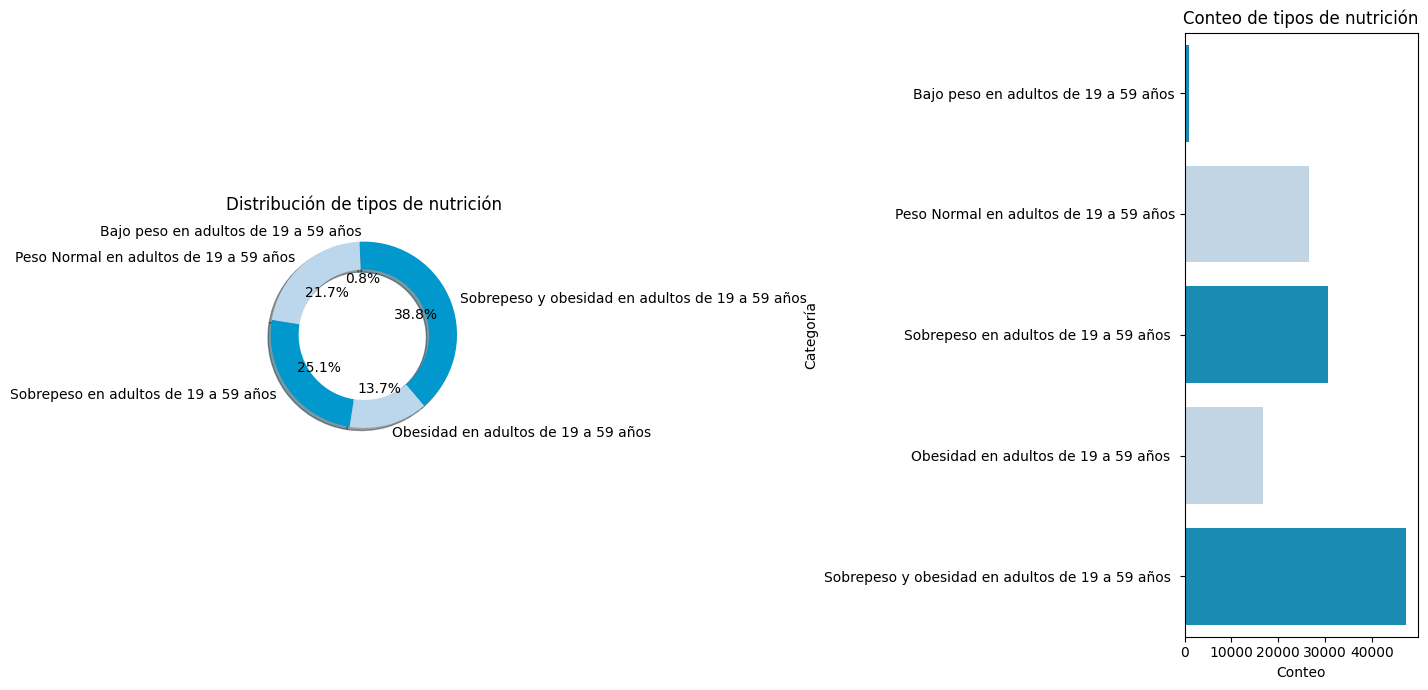

In [ ]:

totals = {
    'Bajo peso en adultos de 19 a 59 años': df['Bajo peso en adultos de 19 a 59 años'].sum(),
    'Peso Normal en adultos de 19 a 59 años': df['Peso Normal en adultos de 19 a 59 años'].sum(),
    'Sobrepeso en adultos de 19 a 59 años ': df['Sobrepeso en adultos de 19 a 59 años '].sum(),
    'Obesidad en adultos de 19 a 59 años ': df['Obesidad en adultos de 19 a 59 años '].sum(),
    'Sobrepeso y obesidad en adultos de 19 a 59 años ': df['Sobrepeso y obesidad en adultos de 19 a 59 años '].sum()
}

totals_df = pd.DataFrame(list(totals.items()), columns=['Category', 'Count'])

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
colors = ['#0098cd', '#bcd6eb']
plt.pie(totals_df['Count'], labels=totals_df['Category'], autopct='%1.1f%%', colors=colors, shadow=True, startangle=90, wedgeprops=dict(width=0.3))
#totals_df.set_index('Category').plot.pie(y='Count', autopct='%1.1f%%', colors=colors, shadow=True, startangle=90, wedgeprops=dict(width=0.3))
plt.title("Distribución de tipos de nutrición")


plt.subplot(1, 2, 2)
colors = ['#0098cd', '#bcd6eb']
sns.barplot(x='Count', y='Category', data=totals_df, palette=colors, hue='Category', dodge=False, legend=False)
plt.title("Conteo de tipos de nutrición")
plt.xlabel('Conteo')
plt.ylabel('Categoría')

# Adjust layout
plt.tight_layout()
plt.show()


### **Creación de columna Ingreso Neto**

In [ ]:
## Se creará una columna de Ingreso Neto, que integrará todas las ganancias que percibe la persona, menos los gastos que tuvo.
## Para esto, inicialmente se deben procesar los valores números de las columnas que serán utilizadas en este paso.

replacement_values = {
    'Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto': 0,
    'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto': 0,
    'Monto.1': 0, #este monto es realmente un gasto, por ende no se suma
    'Monto.2': 0,
    'Monto.3': 0,
    'Monto.4': 0,
    'Monto.5': 0,
    'Monto.6': 0,
    'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto': 0,
    'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto': 0,
    'Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto':0
}

df.fillna(replacement_values, inplace=True)


## Crear una columna para el ingreso neto sumando los montos relevantes y restando los descuentos
df['Ingreso_total'] = df[['Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto',
                        'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto',
                        #'Monto.1',
                        'Monto.2', 'Monto.3', 'Monto.4', 'Monto.5', 'Monto.6',
                        'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto',
                        'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto']].sum(axis=1, skipna=True)

df['Ingreso_neto'] = df['Ingreso_total'] - df['Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto']


### **Subset por columnas**

In [ ]:
columnas_seleccionadas = [
    'Área',
    'Provincia',
    'Sexo',
    'Edad',
    #'Grupo edad en años', #esta es redundante porque ya tenemos la edad
    'Parentesco con el jefe (a) de hogar',
    'Cuál es su Estado Civil ó Conyugal',
    'Identificación étnica',
    'Estratos',
    'Nivel de instrucción más alto que aprobó _Nivel',
    'Año de instrucción más alto que aprobó _Año',
    'Sabe leer y escribir',
    'Por los estudios realizados obtuvo algún título superior',
    'Está afiliado o cubierto _Alt1',
    'Está afiliado o cubierto _Alt2',
    'Tiene dificultad para ver, aunque sea con lentes',
    'Tiene dificultad para oír, incluso si utiliza un audífono',
    'Tiene dificultad para caminar o subir escaleras',
    'Tiene dificultad para recordar o concentrarse',
    'Tiene dificultad para bañarse o vestirse',
    'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
    'Principalmente donde acude o acudiría para tratar sus problemas de salud',
    'Cómo calificaría el estado de salud actual ',
    'Comparando el estado de salud actual y con el de hace un año',
    'Asiste, actualmente a clases',
    'Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ',
    'Tiempo que busca trabajo',
    'Está disponible para trabajar',
    'Cuántos trabajos tuvo, en la semana pasada',
    'Qué hizo la semana pasada',
    'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
    'Recibe el Bono de desarrollo humano',
    'En el lugar indicado, trabaja o trabajó como',
    'Ingreso_neto',
    'Tuvo algún parto  _últimos 12 meses ',
    'Peso',
    'Talla',
    'Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años ',
    ]


In [ ]:
df = df[columnas_seleccionadas]

In [ ]:
# Cantidad de columnas después del filtrado
len(df.columns)

40

In [ ]:
df.head(5)

Área  Provincia    Sexo  Edad Parentesco con el jefe (a) de hogar Cuál es su Estado Civil ó Conyugal Identificación étnica  Estratos Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Por los estudios realizados obtuvo algún título superior Está afiliado o cubierto _Alt1 Está afiliado o cubierto _Alt2 Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Principalmente donde acude o acudiría para tratar sus problemas de salud Cómo calificaría el estado de salud actual  Comparando el estado de salud actual y con el de hace un año Asiste, actualmente a clases Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar   Tiempo que busca trabajo Está disponible para trabajar Cuántos trabajos tuvo, en la semana pasada   Qué hizo la semana pasada Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc. Recibe el Bono de desarrollo humano En el lugar indicado, trabaja o trabajó como  Ingreso_neto Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años 
0   urbano          1  hombre    28                     jefe/a de hogar                        unión libre               Mestizo      2713                                        primaria                                          6.0                   si                                                NaN                iess, seguro general?                       ninguno?                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                         medicina general(convencional)?                                                            bueno?                                             igual?                                     no                                                NaN                                                                                NaN                           NaN                                        uno  trabajó al menos una hora?                                                 no                                                                                                          no               empleado(a)/obrero(a) privado?         440.0                                  NaN   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0
6   urbano          1   mujer    36                     jefe/a de hogar                        unión libre               Mestizo      2713                                      secundaria                                          5.0                  NaN                                                NaN                             ninguno?                       ninguno?                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                         medicina general(convencional)?                                                            bueno?                                             igual?                               

In [ ]:
df.shape

(75257, 40)

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


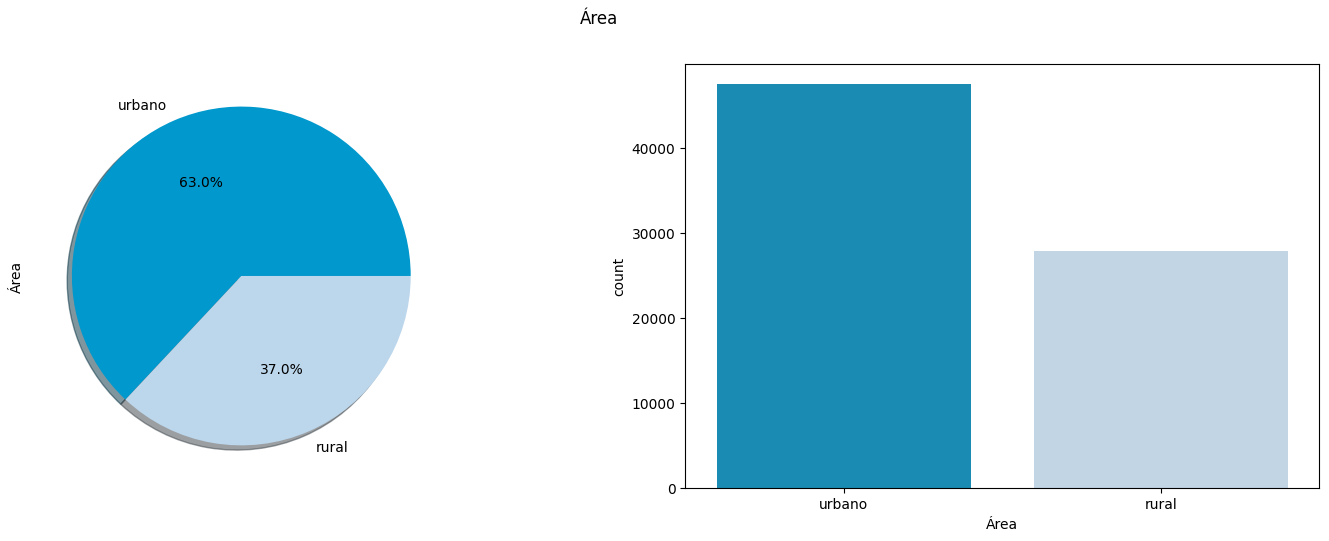

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


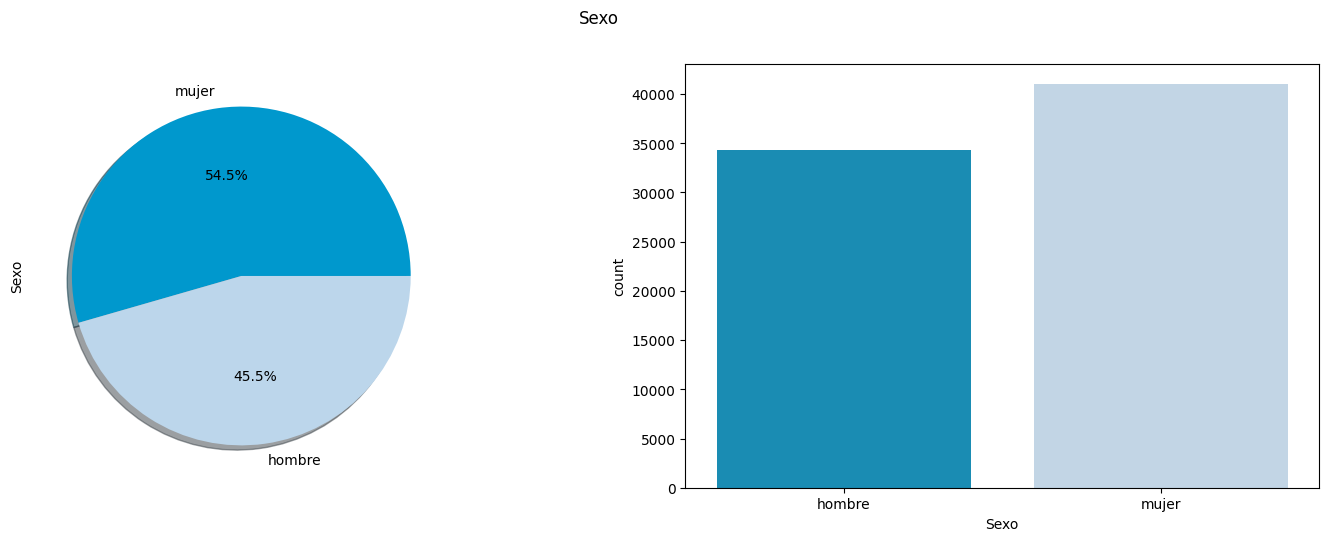

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


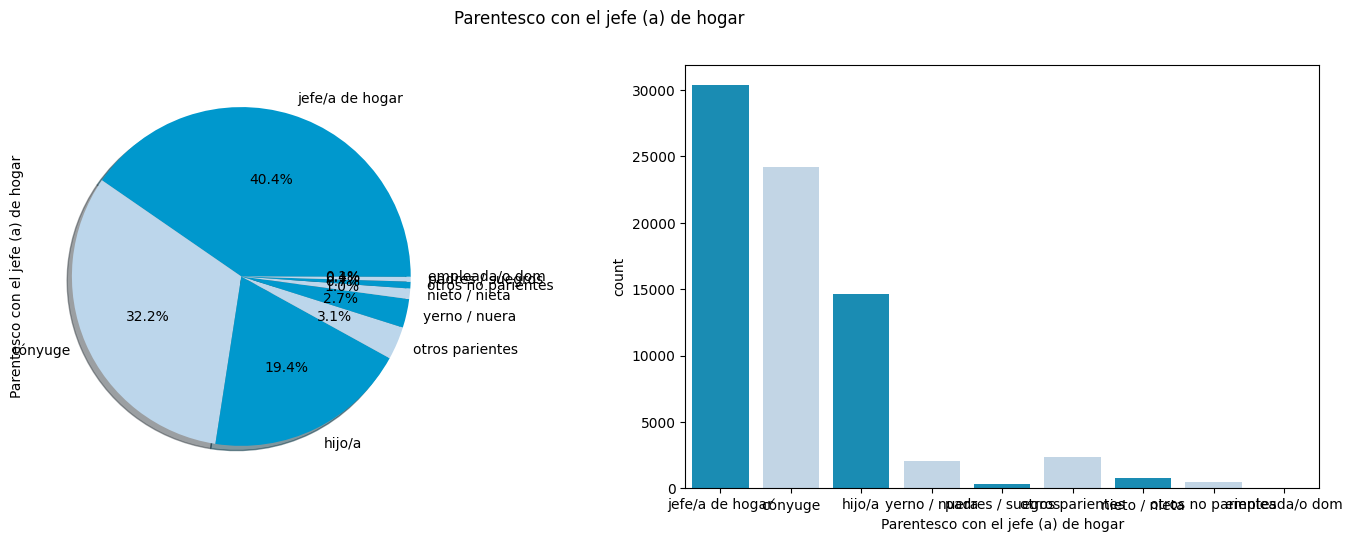

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


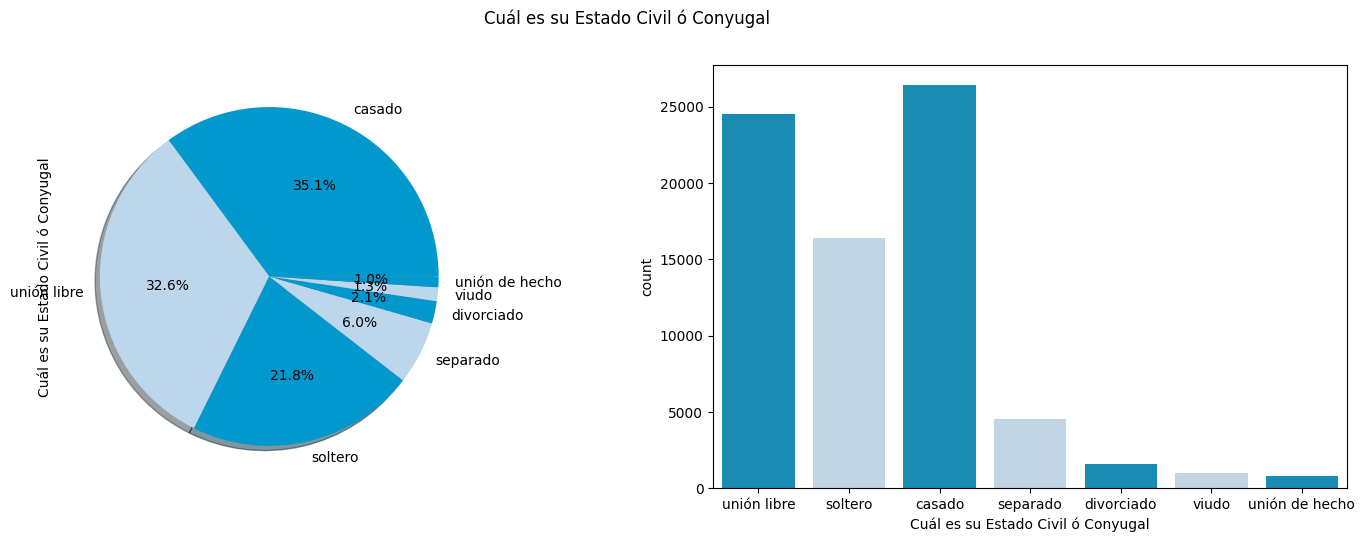

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


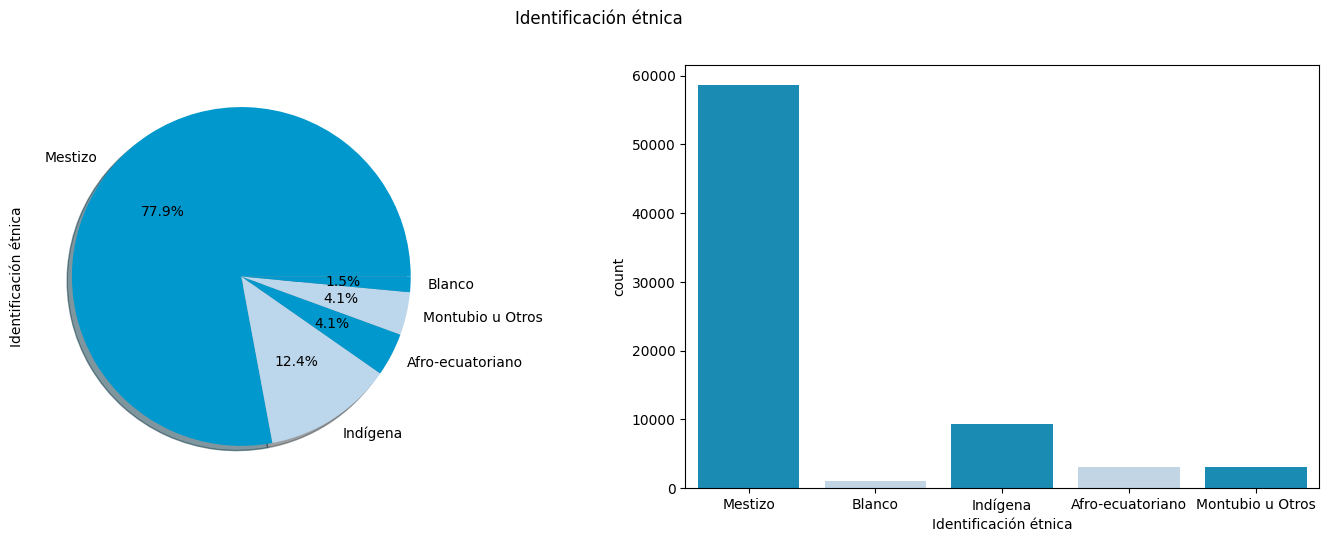

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


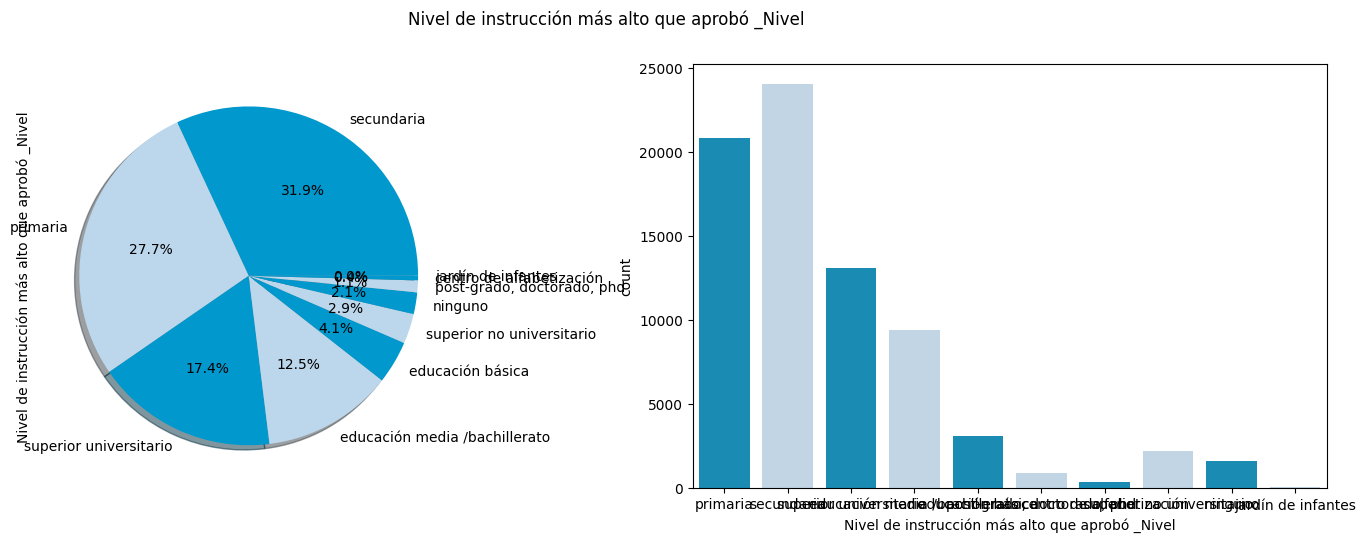

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


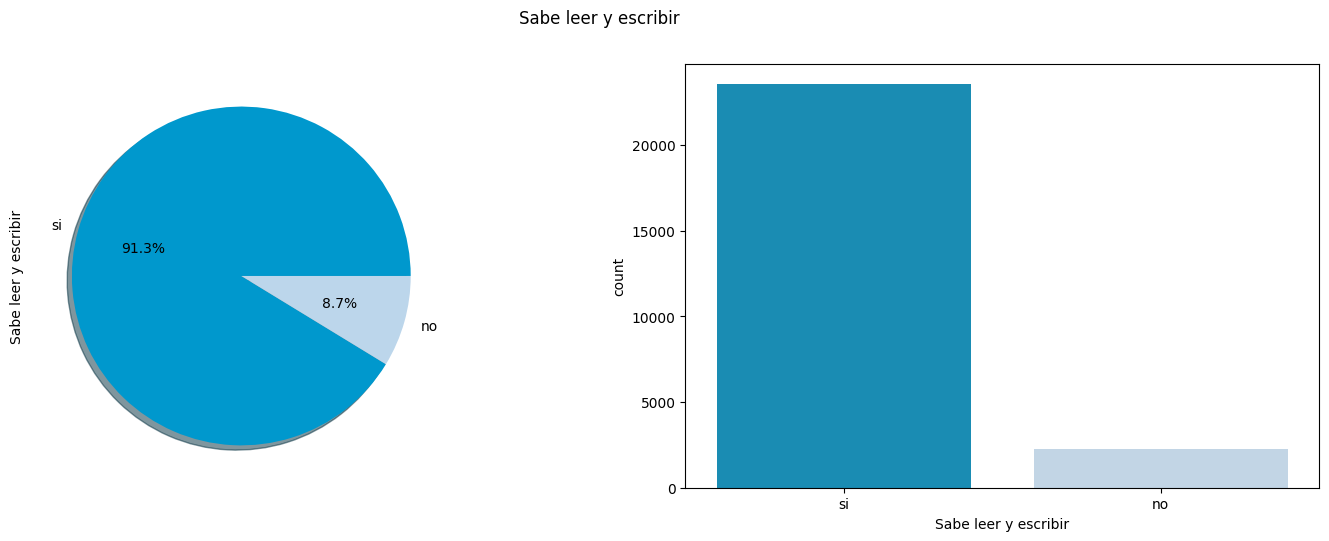

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


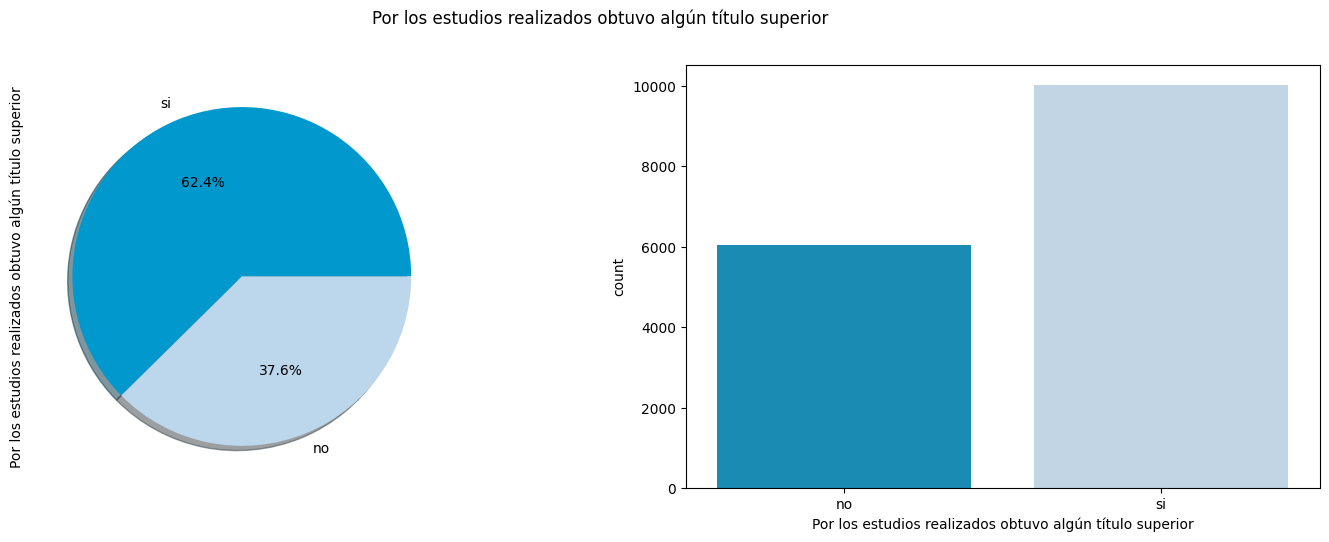

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


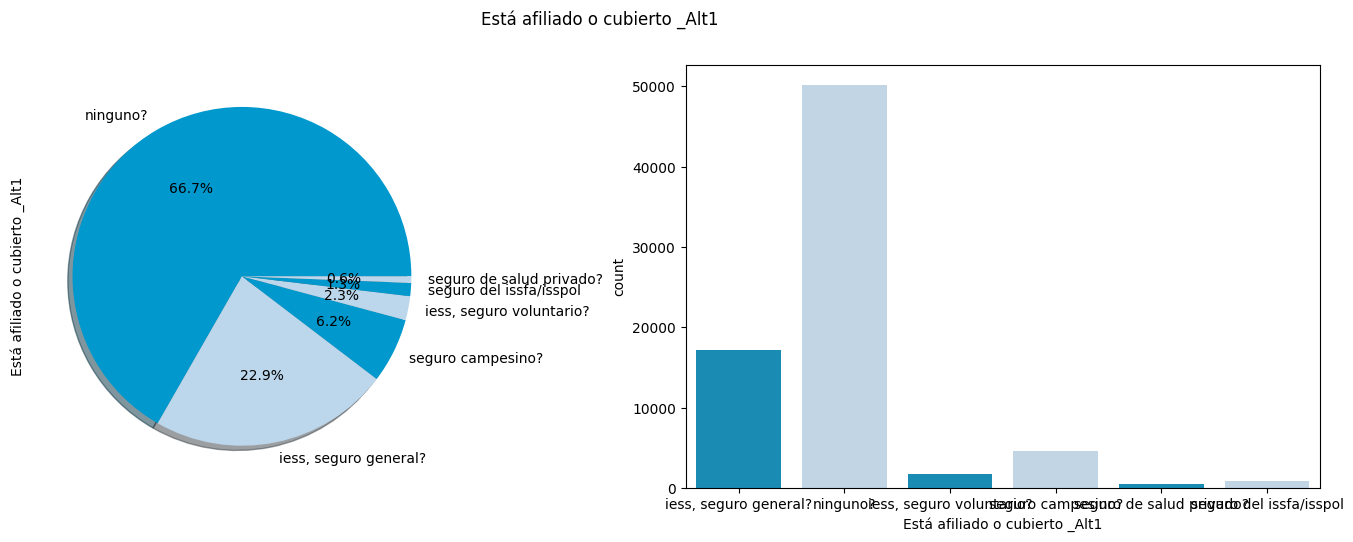

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


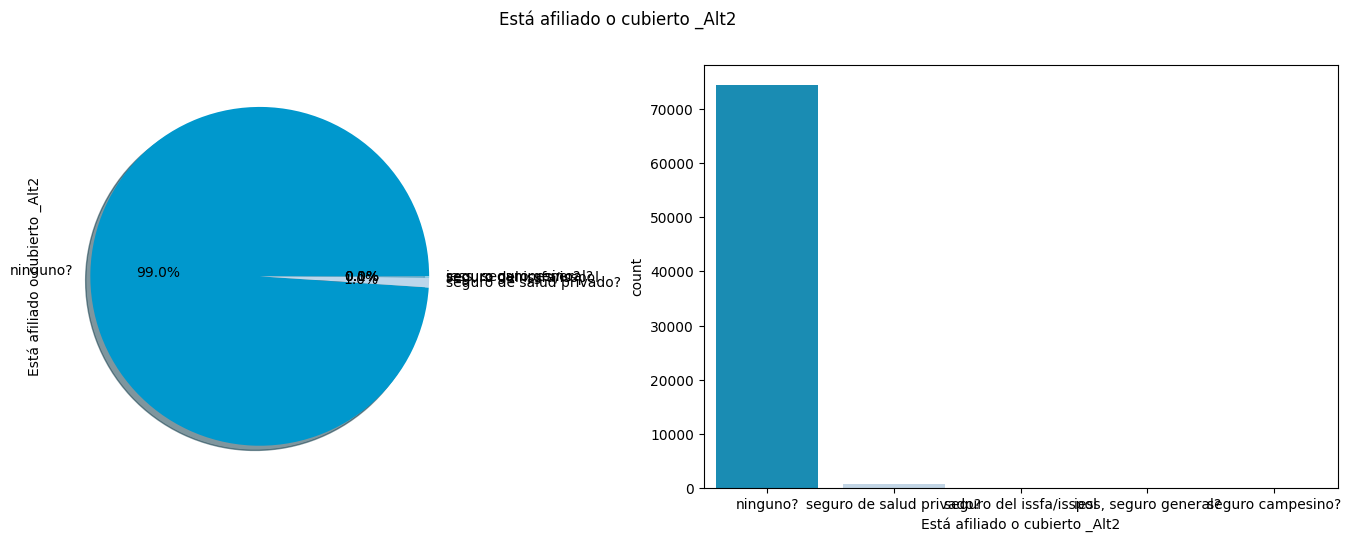

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


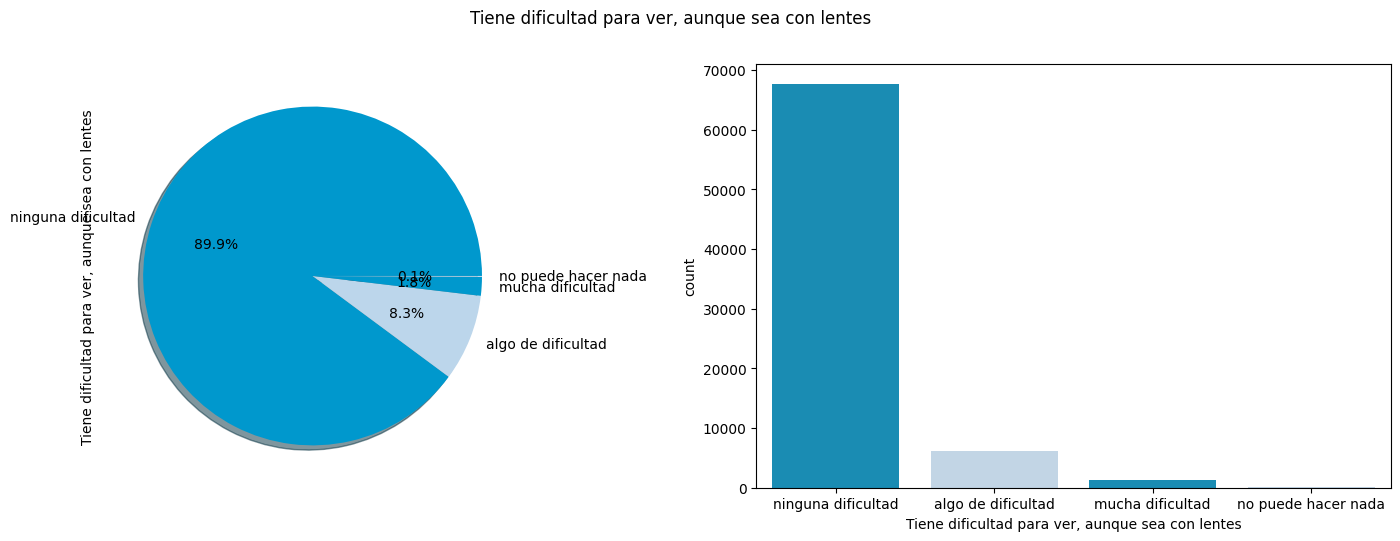

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


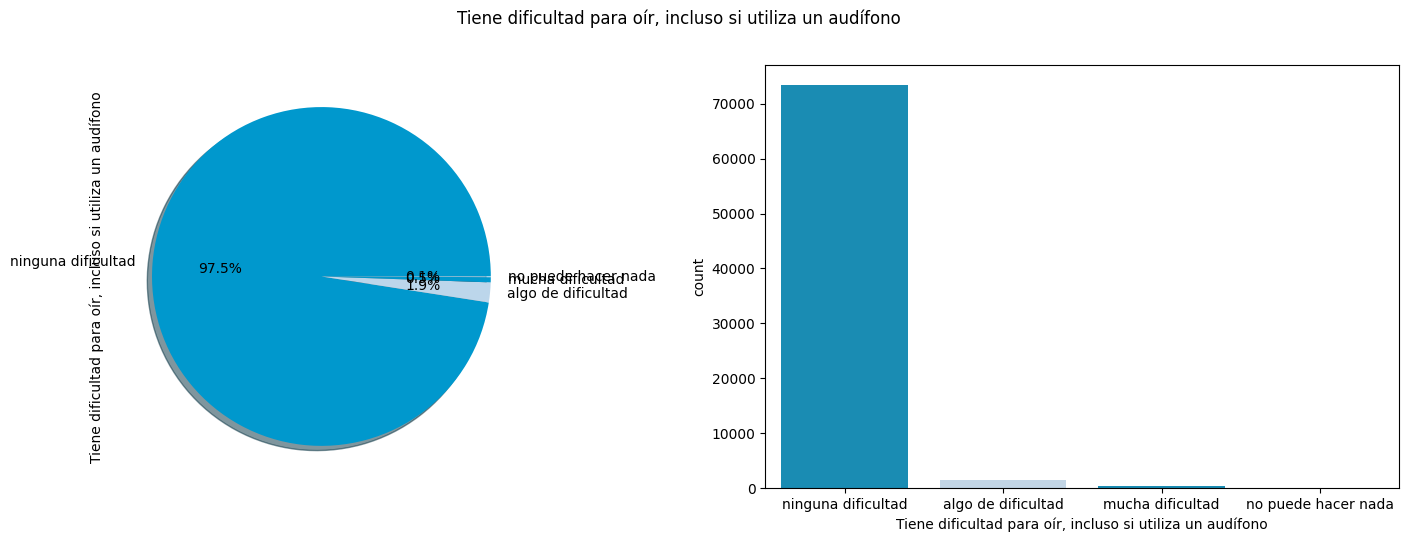

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


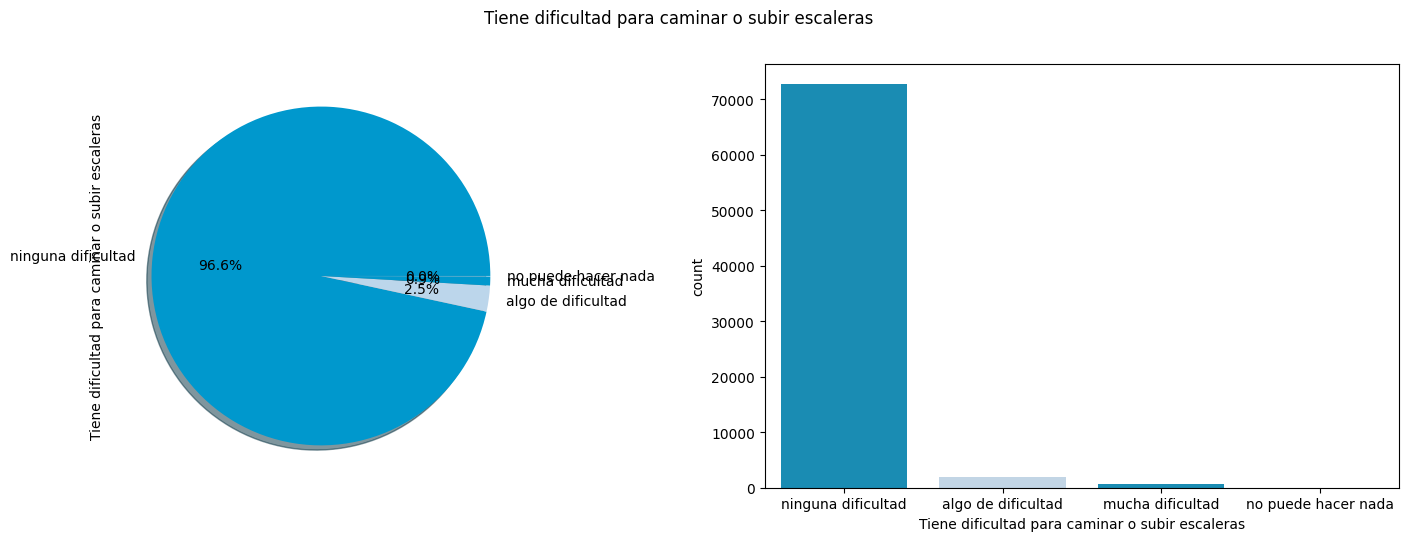

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


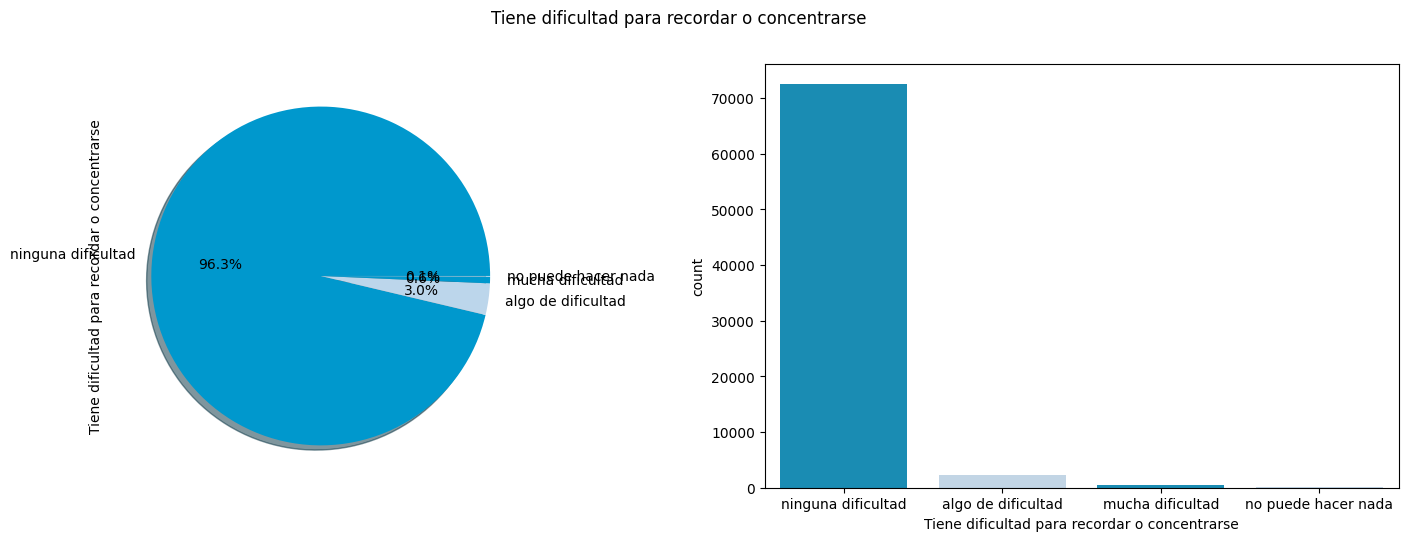

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


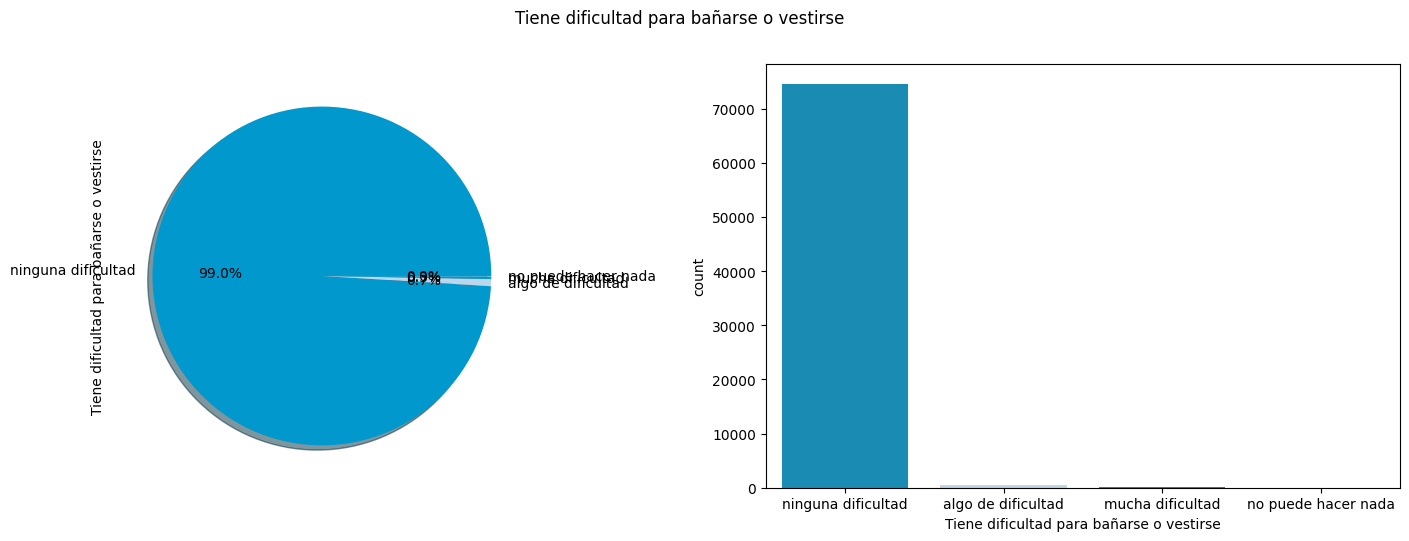

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


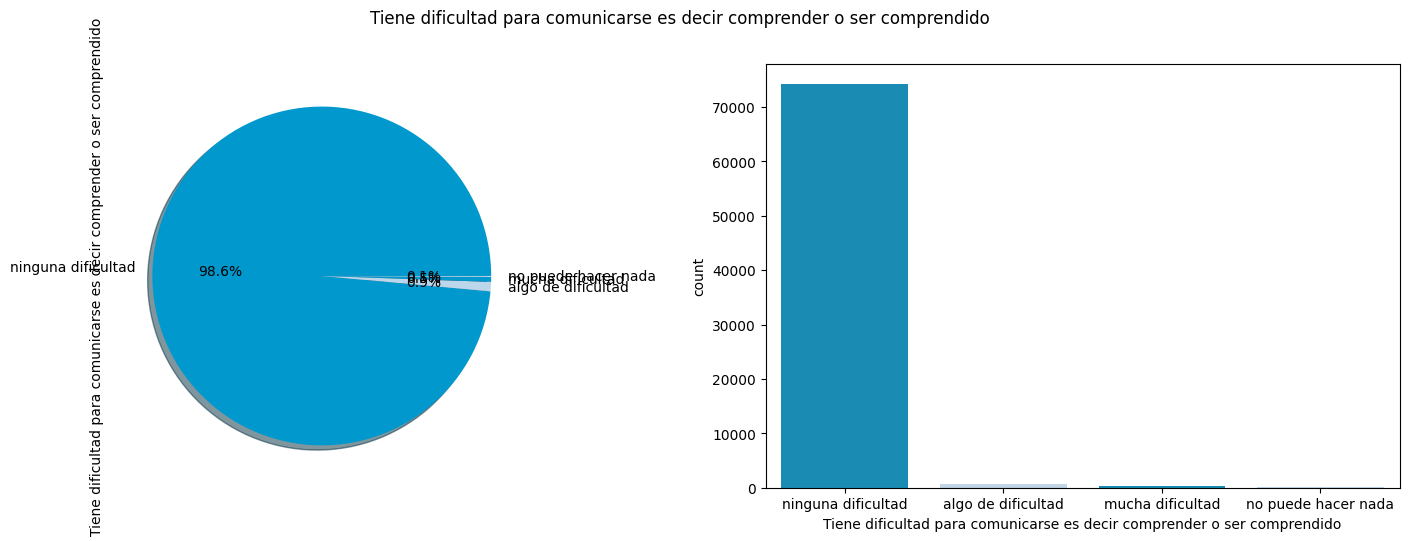

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


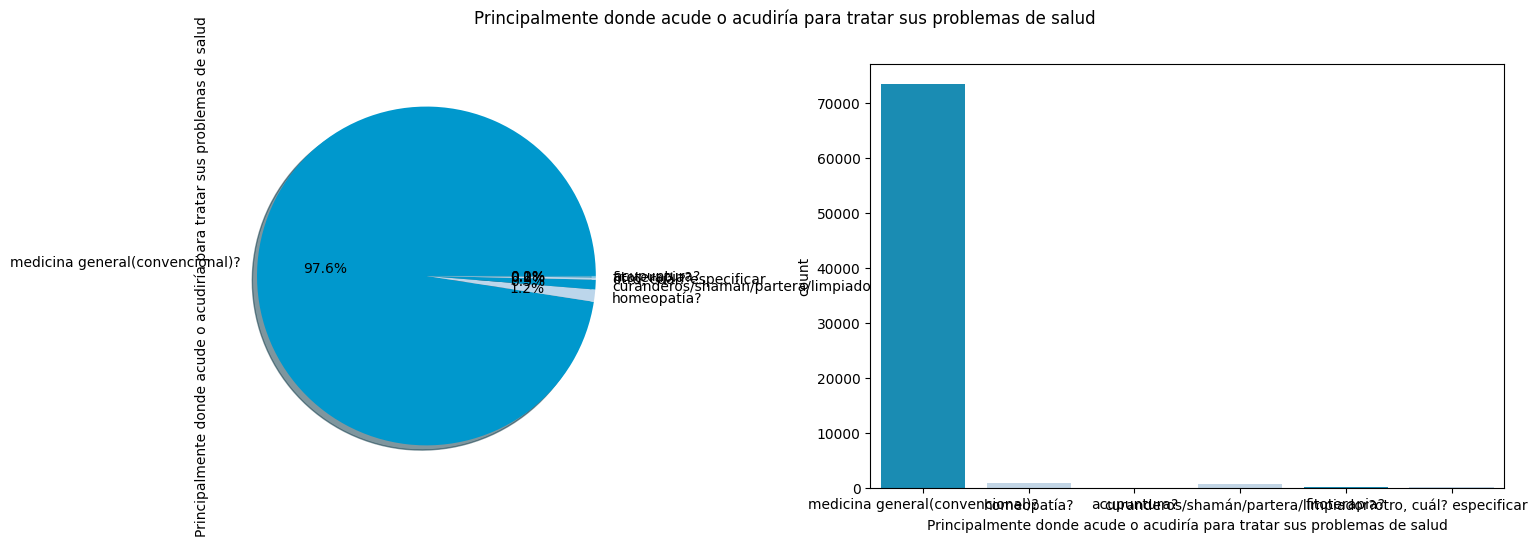

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


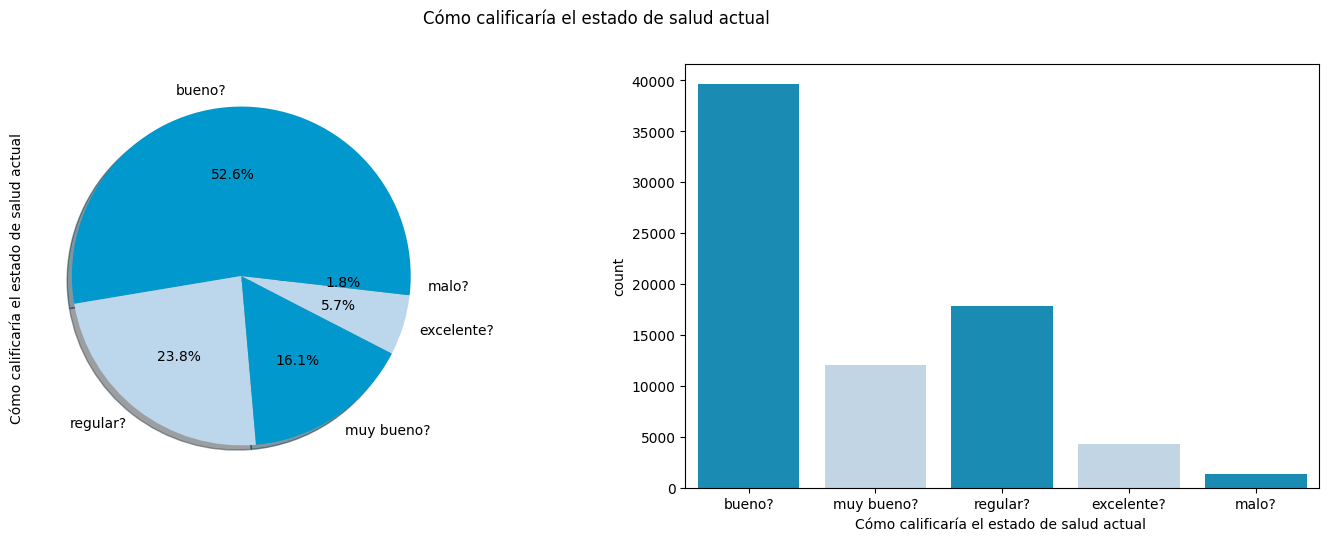

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


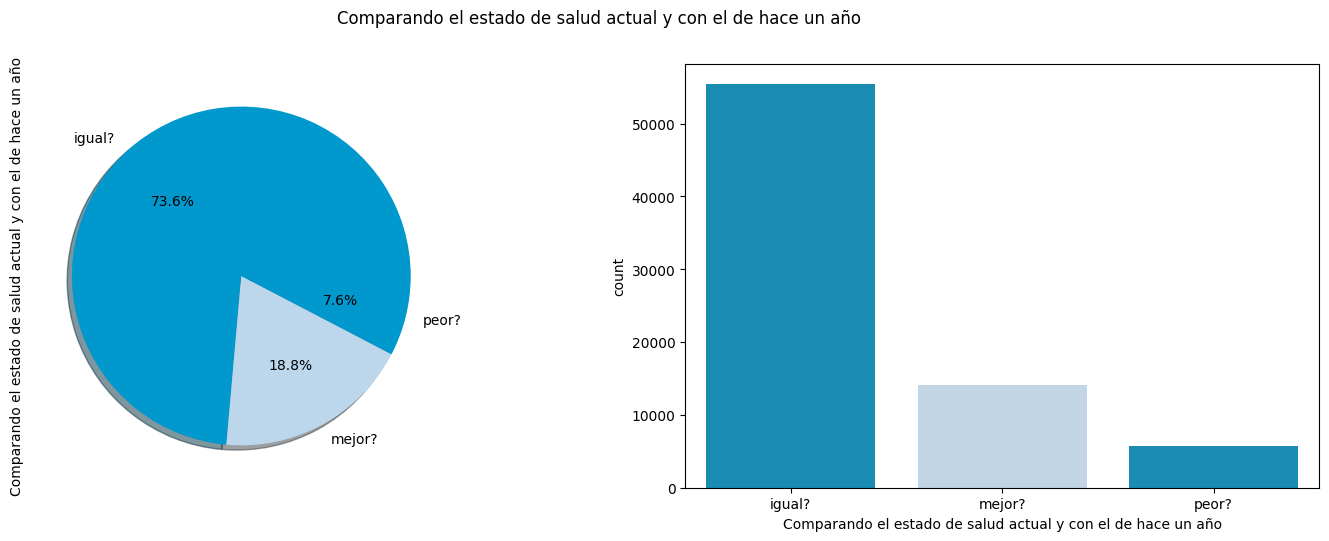

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


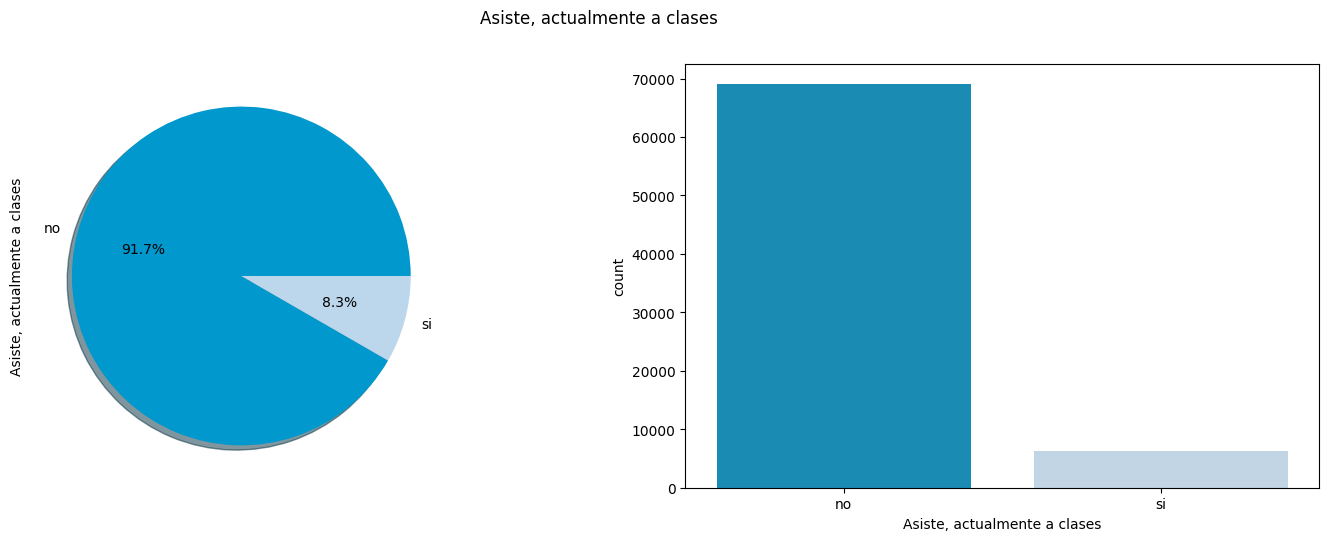

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


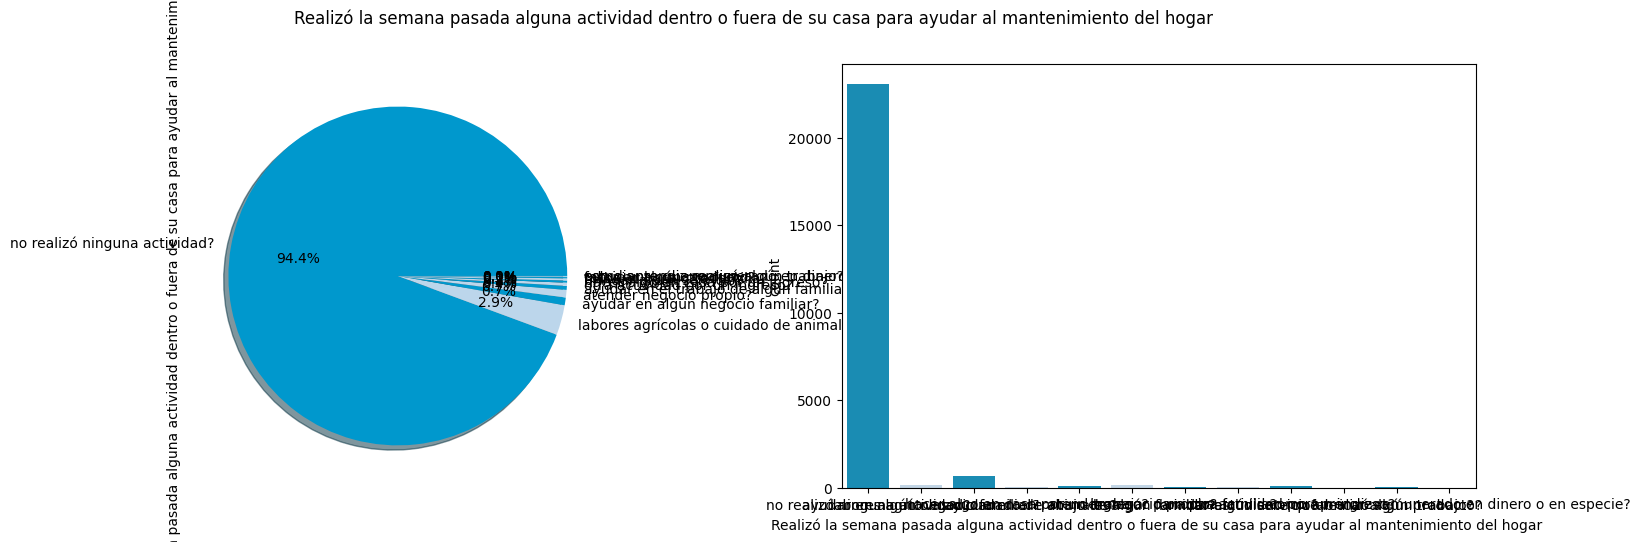

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


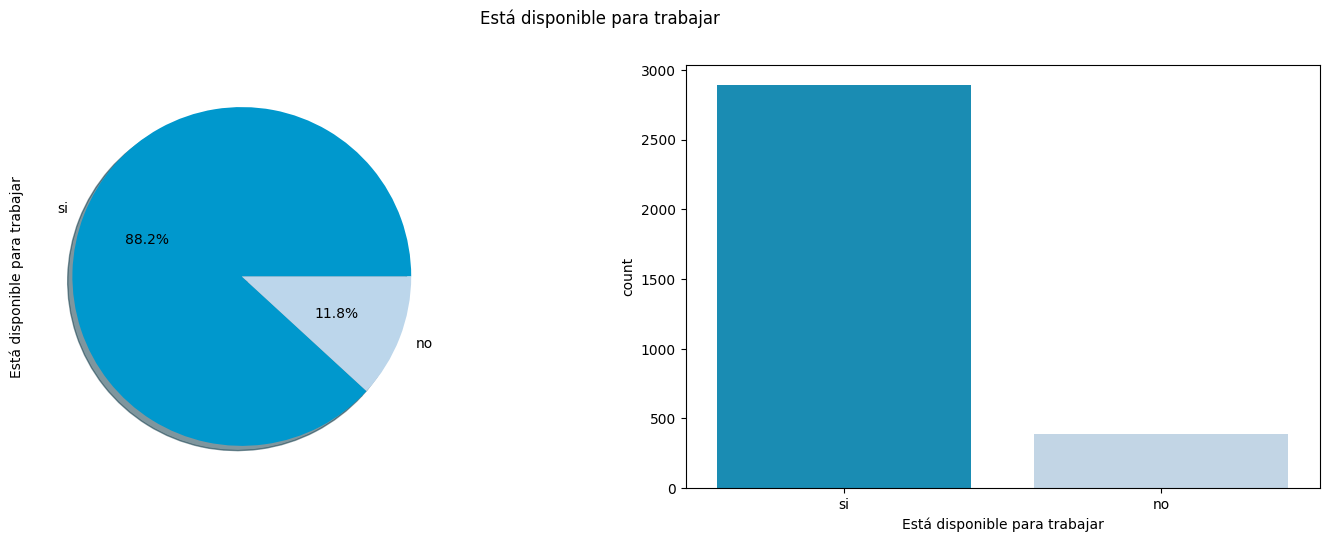

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


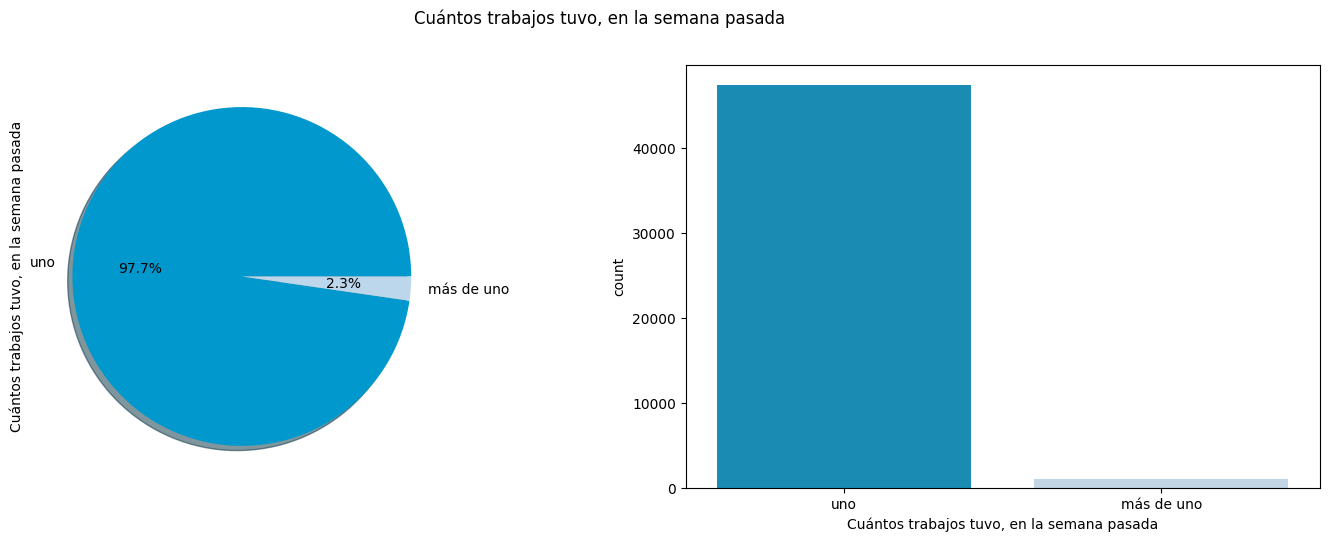

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


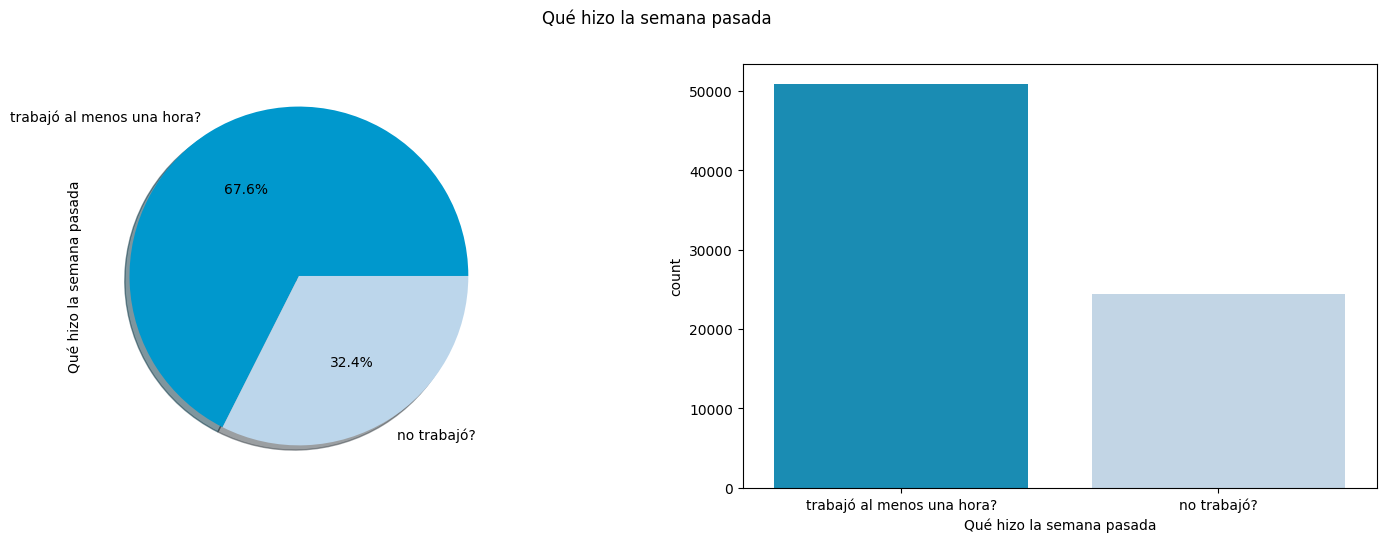

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


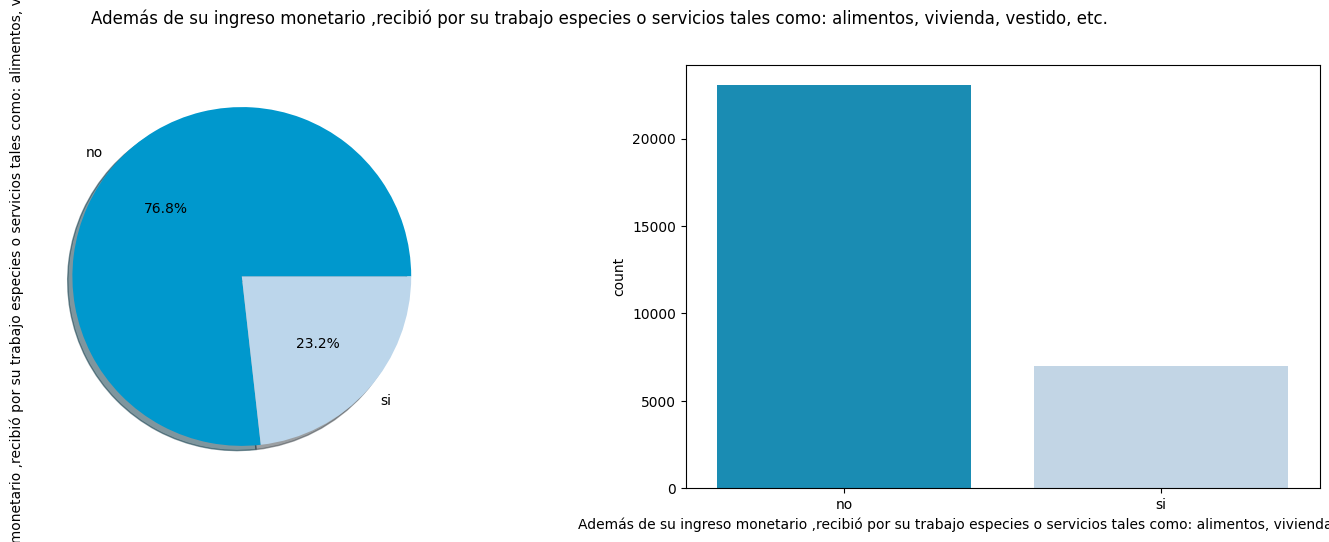

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


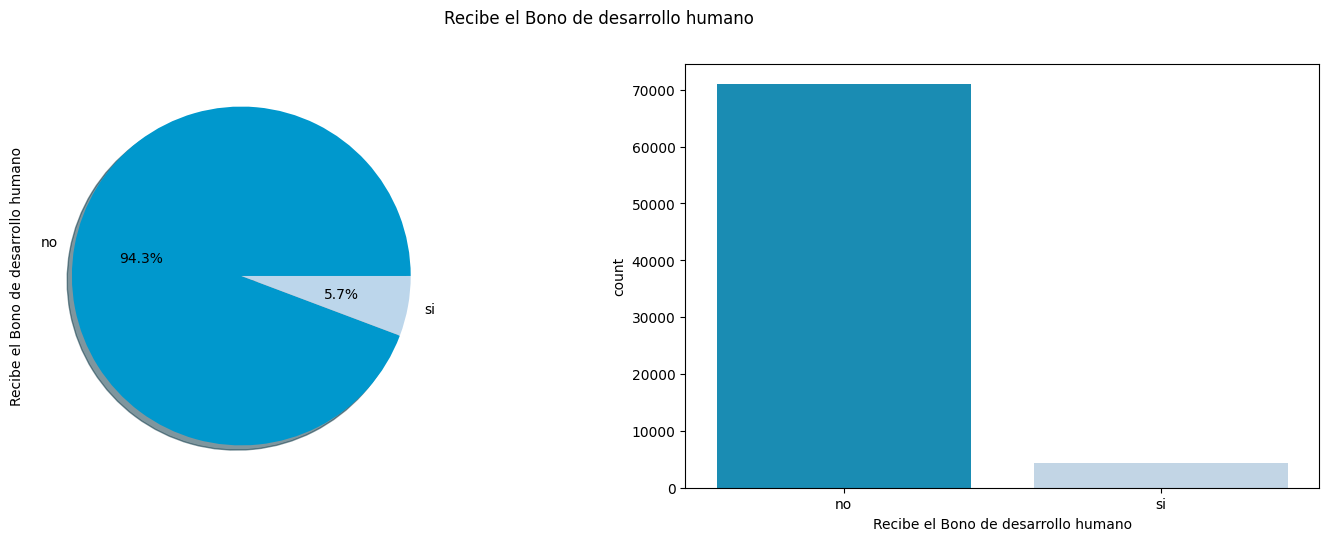

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-18-994c39ab03cb>:9: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


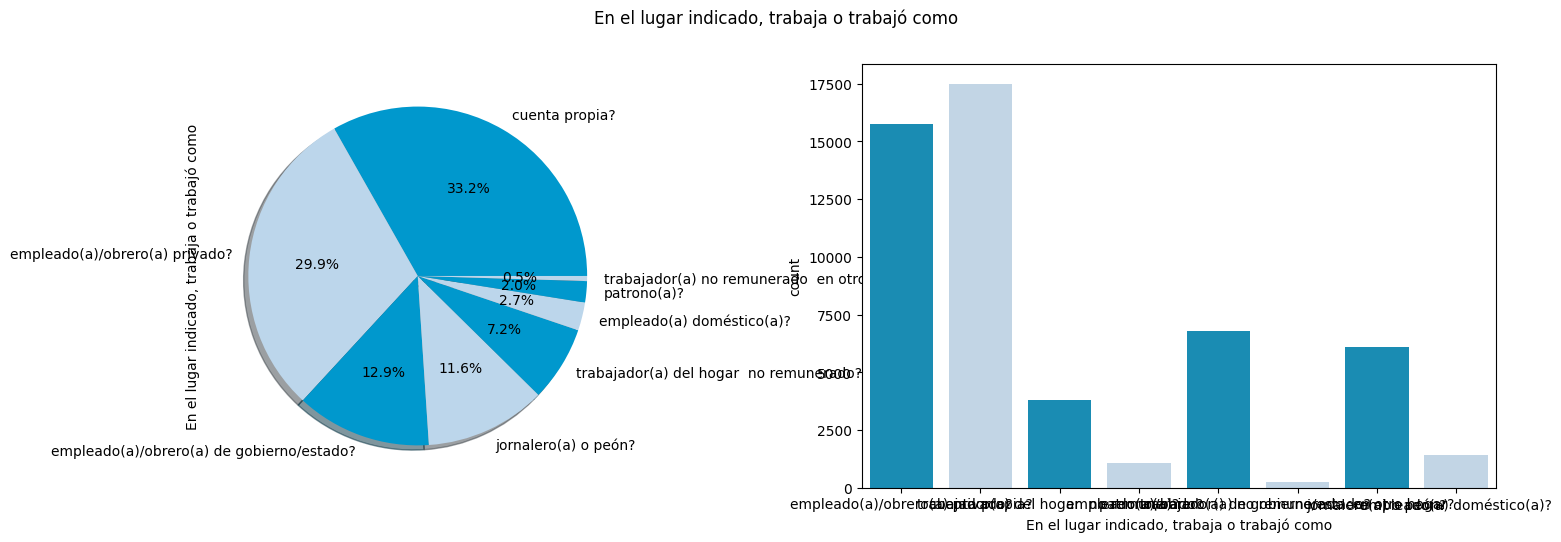

<ipython-input-18-994c39ab03cb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


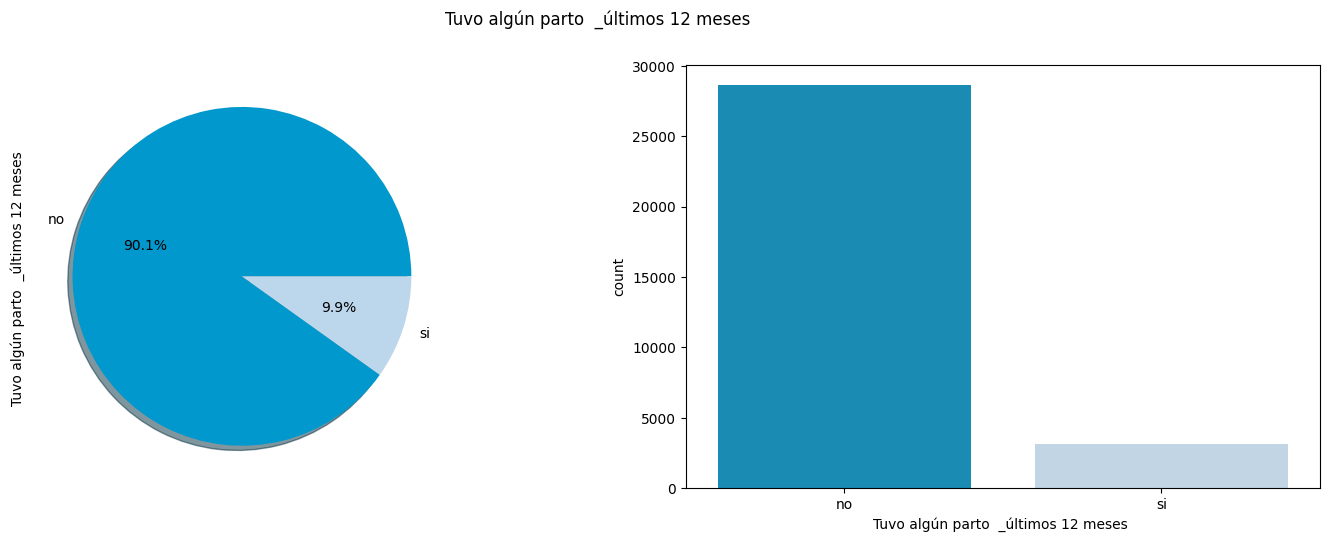

In [ ]:
# Obtener todas las columnas categóricas
categorical_vars = [column for column in df.columns if df[column].dtype == 'object']
# Especificar los colores deseados
colors = ['#0098cd', '#bcd6eb']
for column in categorical_vars:
    f,ax = plt.subplots(1,2,figsize = (18,5.5))
    df[column].value_counts().plot.pie(autopct = '%1.1f%%',ax = ax[0],shadow = True, colors=colors)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
    plt.suptitle(f'{column}')
    plt.show()

### **Imputación de Nulos**

In [ ]:
#Porcentaje de valores nulos en cada columna
df.isnull().mean().round(4)*100

Área                                                                                                                           0.00
Provincia                                                                                                                      0.00
Sexo                                                                                                                           0.00
Edad                                                                                                                           0.00
Parentesco con el jefe (a) de hogar                                                                                            0.00
Cuál es su Estado Civil ó Conyugal                                                                                             0.00
Identificación étnica                                                                                                          0.00
Estratos                                                                    

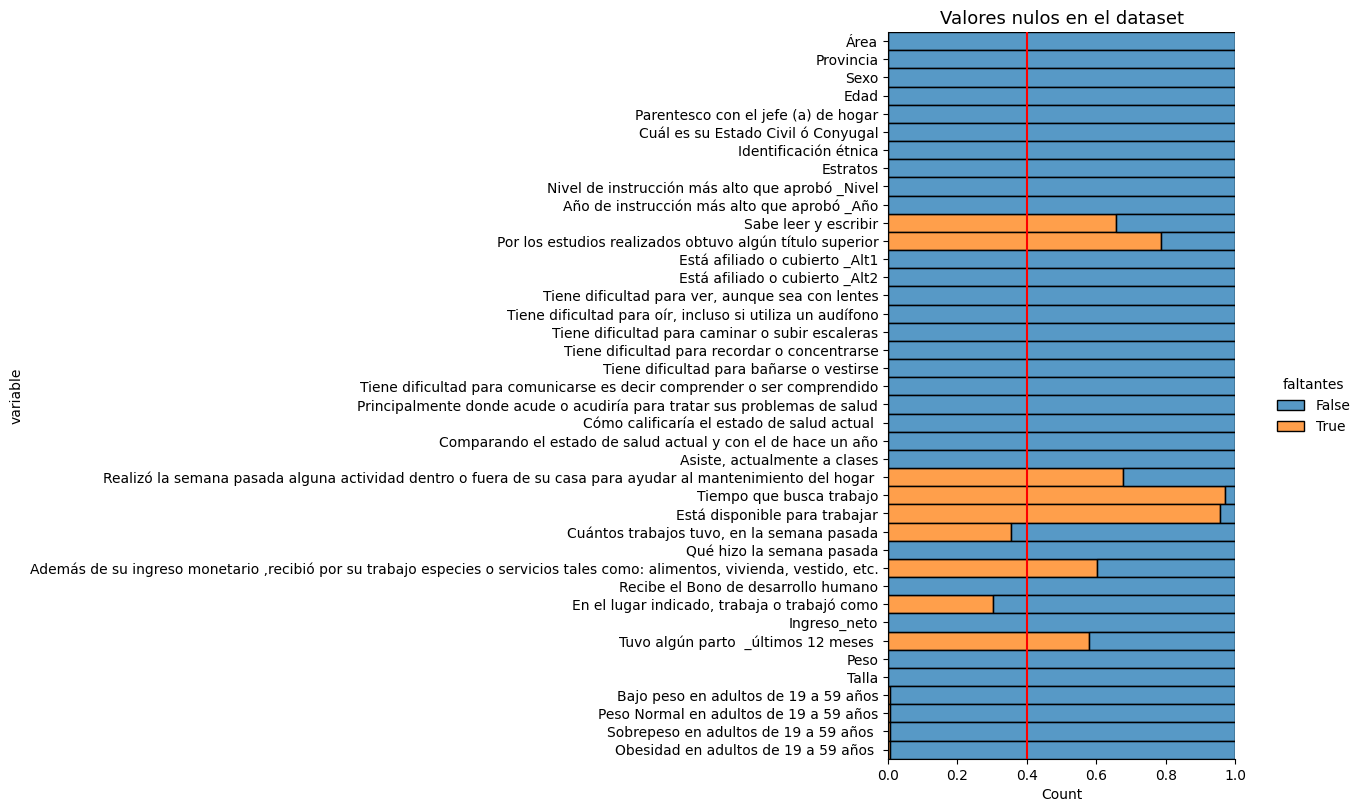

In [ ]:
sns.displot(data=df.isnull().melt(value_name = 'faltantes'),
           y = 'variable',
           hue = 'faltantes',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Valores nulos en el dataset",fontsize = 13)
plt.show()

In [ ]:
df = df.drop([
    'Tiempo que busca trabajo',
    'Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ',
    'Está disponible para trabajar'
], axis=1) #Eliminación de columnas por tener alta tasa de valores nulos

df['Cuántos trabajos tuvo, en la semana pasada'] = df['Cuántos trabajos tuvo, en la semana pasada'].fillna("cero")

df['Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.'] = df['Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.'].fillna("no")

df['Recibe el Bono de desarrollo humano'] = df['Recibe el Bono de desarrollo humano'].fillna("no")

df['En el lugar indicado, trabaja o trabajó como'] = df['En el lugar indicado, trabaja o trabajó como'].fillna("no trabaja")

df['Tuvo algún parto  _últimos 12 meses '] = df['Tuvo algún parto  _últimos 12 meses '].fillna("no")

df["Sabe leer y escribir"] = df["Sabe leer y escribir"].fillna("si")

df["Por los estudios realizados obtuvo algún título superior"] = df["Por los estudios realizados obtuvo algún título superior"].fillna("no")



In [ ]:
df.shape

(75257, 37)

In [ ]:
# Eliminación de instancias sin datos
df=df.dropna(subset=['Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años '])

In [ ]:
# Crear la columna IMC, convirtiendo la talla de cm a metros en el cálculo
df['IMC'] = df['Peso'] / ((df['Talla'] / 100) ** 2)

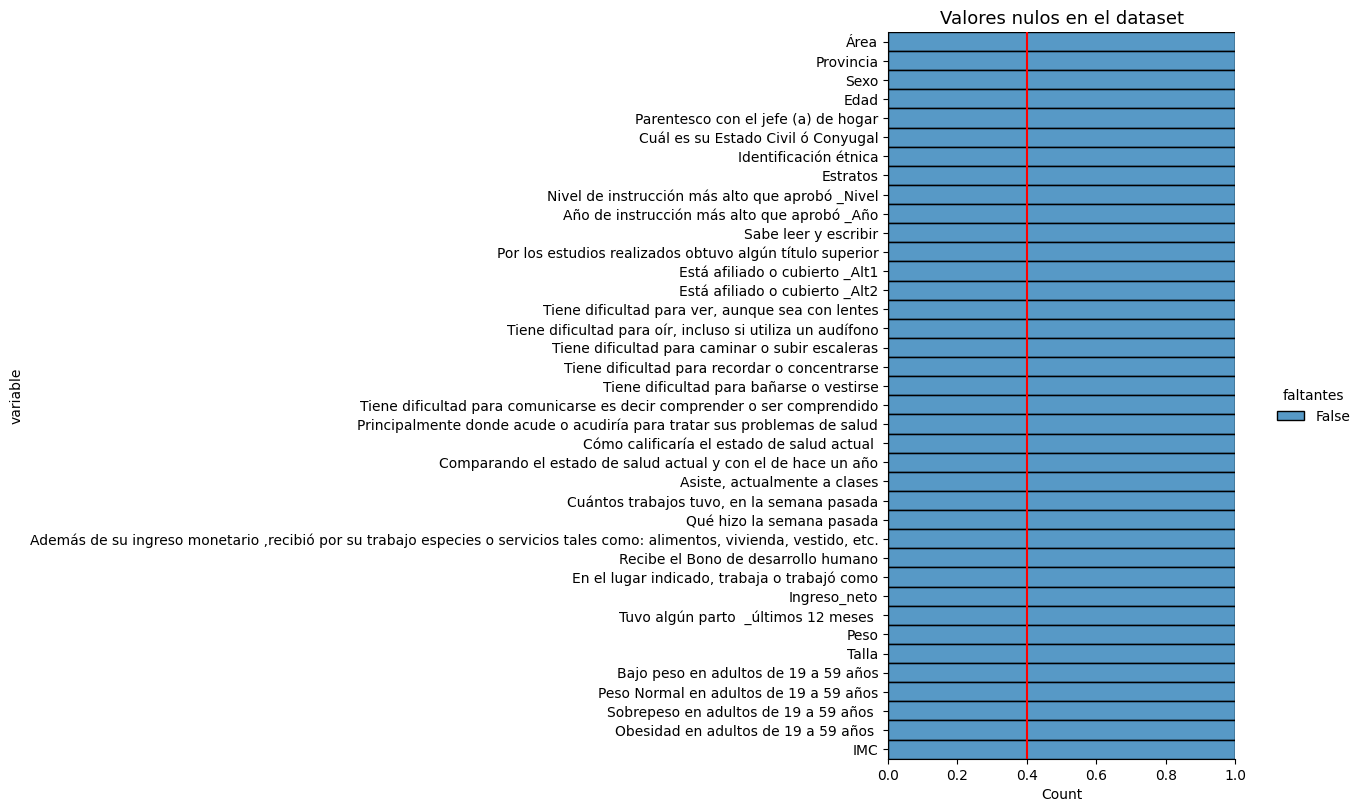

In [ ]:
# Visualización de nulos
sns.displot(data=df.isnull().melt(value_name = 'faltantes'),
           y = 'variable',
           hue = 'faltantes',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Valores nulos en el dataset",fontsize = 13)
plt.show()

### **Eliminación de signo (?)**

In [ ]:
df = df.replace('\?', '', regex=True)

### **Ingeniería de características y creación de columnas para reducir dimensionalidad**


#### **Creación de nueva columna de "años totales de estudio"**

In [ ]:
df['Nivel de instrucción más alto que aprobó _Nivel'].unique()

array(['primaria', 'secundaria', 'superior universitario',
       'educación media /bachillerato', 'educación básica',
       'post-grado, doctorado, phd', 'centro de alfabetización',
       'superior no universitario', 'ninguno', 'jardín de infantes'],
      dtype=object)

In [ ]:
df['Año de instrucción más alto que aprobó _Año'].unique()

array([ 6.,  5.,  1.,  2.,  3., 10.,  4.,  7.,  0.,  9.,  8.])

In [ ]:
# Asignar 'ninguno' a la columna de nivel de instrucción si el año de instrucción es 0
df.loc[df['Año de instrucción más alto que aprobó _Año'] == 0, 'Nivel de instrucción más alto que aprobó _Nivel'] = 'ninguno'

In [ ]:
# Función para calcular los años totales de estudio
def calcular_anios_totales(row):
    if row['Nivel de instrucción más alto que aprobó _Nivel'] == 'ninguno':
        return 0
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'jardín de infantes':
        return 1
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'centro de alfabetización':
        return 1
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] in ['primaria', 'educación básica']:
        return row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'secundaria':
        return 6 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'educación media /bachillerato':
        return 9 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] in ['superior no universitario', 'superior universitario']:
        return 12 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'post-grado, doctorado, phd':
        return 16 + row['Año de instrucción más alto que aprobó _Año']
    else:
        return 0  # Para manejar cualquier otro caso no considerado

# Aplicar la función a cada fila para crear la nueva columna
df['años_totales_estudio'] = df.apply(calcular_anios_totales, axis=1)

# Mostrar las primeras filas para verificar
df.sample(5)

Área  Provincia    Sexo  Edad Parentesco con el jefe (a) de hogar Cuál es su Estado Civil ó Conyugal Identificación étnica  Estratos Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Por los estudios realizados obtuvo algún título superior Está afiliado o cubierto _Alt1 Está afiliado o cubierto _Alt2 Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Principalmente donde acude o acudiría para tratar sus problemas de salud Cómo calificaría el estado de salud actual  Comparando el estado de salud actual y con el de hace un año Asiste, actualmente a clases Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc. Recibe el Bono de desarrollo humano En el lugar indicado, trabaja o trabajó como  Ingreso_neto Tuvo algún parto  _últimos 12 meses        Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años         IMC  años_totales_estudio
164583  urbano         24   mujer    55                              hijo/a                           separado               Mestizo      2412                                        primaria                                          6.0                   si                                                 no                              ninguno                        ninguno                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                          medicina general(convencional)                                                           regular                                              igual                                     no                                        uno                 no trabajó                                                 no                                                                                                          no                empleado(a)/obrero(a) privado          35.0                                   no  51.799999  148.89999                                   0.0                                     1.0                                    0.0                                   0.0  23.363635                   6.0
81124   urbano         12   mujer    43                             cónyuge                        unión libre               Mestizo      1213                                        primaria                                          6.0                   si                                                 no                              ninguno                        ninguno                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                          medicina general(convencional)                                                           regular                                              igual                                     no                                        uno  trabajó al menos una hora                                                 no                                                                                                          no                     

In [ ]:
# Una vez creada la columna de años totales de estudio, podemos eliminar las columnas redundantes de Nivel y Año
df = df.drop(['Nivel de instrucción más alto que aprobó _Nivel', 'Año de instrucción más alto que aprobó _Año'], axis=1)

#### **Union de columnas de afiliacion a seguros (medicos o sociales) y transformacion en numerica**

In [ ]:
df['Está afiliado o cubierto _Alt1'].unique()

array(['iess, seguro general', 'ninguno', 'iess, seguro voluntario',
       'seguro campesino', 'seguro de salud privado',
       'seguro del issfa/isspol'], dtype=object)

In [ ]:
df['Está afiliado o cubierto _Alt2'].unique()

array(['ninguno', 'seguro de salud privado', 'seguro del issfa/isspol',
       'iess, seguro general', 'seguro campesino'], dtype=object)

In [ ]:
# Para crear una sola columna numérica sobre la afiliación
# Reemplazar valores en las columnas
df['Está afiliado o cubierto _Alt1'] = df['Está afiliado o cubierto _Alt1'].apply(lambda x: 0 if 'ninguno' in x.lower() else 1)
df['Está afiliado o cubierto _Alt2'] = df['Está afiliado o cubierto _Alt2'].apply(lambda x: 0 if 'ninguno' in x.lower() else 1)

# Crear la nueva columna sumando las dos anteriores
df['num_afiliaciones'] = df['Está afiliado o cubierto _Alt1'] + df['Está afiliado o cubierto _Alt2']

In [ ]:
# Una vez creada la columna del total de afiliaciones, podemos eliminar las columnas sobre qué afiliaciones tiene porque sería redundante
df = df.drop(['Está afiliado o cubierto _Alt1', 'Está afiliado o cubierto _Alt2'], axis=1)


#### **Suma de las columnas de dificultades**

In [ ]:
lista_dif =['Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido']

for col in lista_dif:
    print(f"Valores únicos en la columna '{col}':")
    print(df[col].unique())
    print()

Valores únicos en la columna 'Tiene dificultad para ver, aunque sea con lentes':
['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Valores únicos en la columna 'Tiene dificultad para oír, incluso si utiliza un audífono':
['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Valores únicos en la columna 'Tiene dificultad para caminar o subir escaleras':
['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Valores únicos en la columna 'Tiene dificultad para recordar o concentrarse':
['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Valores únicos en la columna 'Tiene dificultad para bañarse o vestirse':
['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Valores únicos en la columna 'Tiene dificultad para comunicarse es decir comprender o ser comprendido':
['ninguna dificultad' 'algo de dificultad' 'mucha dificulta

In [ ]:
# Crear un diccionario para mapear las categorías a valores numéricos
# A mayor dificultad, mayor el valor asignado.
dificultad_map = {
    'ninguna dificultad': 0,
    'algo de dificultad': 1,
    'mucha dificultad': 2,
    'no puede hacer nada': 3
}

# Lista de columnas a mapear y sumar
lista_dif = [
    'Tiene dificultad para ver, aunque sea con lentes',
    'Tiene dificultad para oír, incluso si utiliza un audífono',
    'Tiene dificultad para caminar o subir escaleras',
    'Tiene dificultad para recordar o concentrarse',
    'Tiene dificultad para bañarse o vestirse',
    'Tiene dificultad para comunicarse es decir comprender o ser comprendido'
]

# Aplicar el mapeo a cada columna en la lista
for col in lista_dif:
    df[col] = df[col].map(dificultad_map)

# Verificar si el mapeo se ha aplicado correctamente
for col in lista_dif:
    print(f"Valores únicos en la columna '{col}':")
    print(df[col].unique())
    print()

# Crear una nueva columna que sume los valores de las columnas en la lista
df['dificultad_total'] = df[lista_dif].sum(axis=1)

# Mostrar el conteo de valores únicos en la nueva columna
print(df['dificultad_total'].value_counts())

Valores únicos en la columna 'Tiene dificultad para ver, aunque sea con lentes':
[0 1 2 3]

Valores únicos en la columna 'Tiene dificultad para oír, incluso si utiliza un audífono':
[0 1 2 3]

Valores únicos en la columna 'Tiene dificultad para caminar o subir escaleras':
[0 1 2 3]

Valores únicos en la columna 'Tiene dificultad para recordar o concentrarse':
[0 1 2 3]

Valores únicos en la columna 'Tiene dificultad para bañarse o vestirse':
[0 1 2 3]

Valores únicos en la columna 'Tiene dificultad para comunicarse es decir comprender o ser comprendido':
[0 1 2 3]

dificultad_total
0     63831
1      6237
2      2715
3       873
4       514
5       211
6       193
7        74
8        61
9        27
10       20
12       15
11        6
18        6
14        1
16        1
13        1
Name: count, dtype: int64


In [ ]:
#Una vez creada la columna de dificultad total podemos eliminar las columnas sobre las dificultades
df = df.drop(lista_dif, axis=1)

#### **Suma de las cols de estado de salud**

In [ ]:
# Crear un diccionario para mapear las categorías a valores numéricos
estado_salud_map = {
    'muy malo': 0,
    'malo': 1,
    'regular': 2,
    'bueno': 3,
    'muy bueno': 4,
    'excelente': 5  # Asumiendo que "excelente" debería tener un valor mayor
}

comparacion_salud_map = {
    'peor': 0,
    'igual': 1,
    'mejor': 2
}

# Aplicar el mapeo a las columnas
df['estado_salud_actual'] = df['Cómo calificaría el estado de salud actual '].map(estado_salud_map)
df['comparacion_salud'] = df['Comparando el estado de salud actual y con el de hace un año'].map(comparacion_salud_map)

# Crear una nueva columna que sume los valores mapeados
df['salud_total'] = df['estado_salud_actual'] + df['comparacion_salud']

# Verificar las primeras filas para asegurarse de que la transformación es correcta
print(df[['estado_salud_actual', 'comparacion_salud', 'salud_total']].head(5))

    estado_salud_actual  comparacion_salud  salud_total
0                     3                  1            4
6                     3                  1            4
7                     4                  1            5
8                     3                  1            4
10                    4                  1            5


In [ ]:
#Eliminar columnas redundantes
df=df.drop(['estado_salud_actual','comparacion_salud','Cómo calificaría el estado de salud actual ','Comparando el estado de salud actual y con el de hace un año'],axis=1)

####**Análisis de correlación entre las columnas creadas y peso**   
Esto tiene el objetivo de validar cuánto pueden incidir estas nuevas columnas en la predicción de IMC



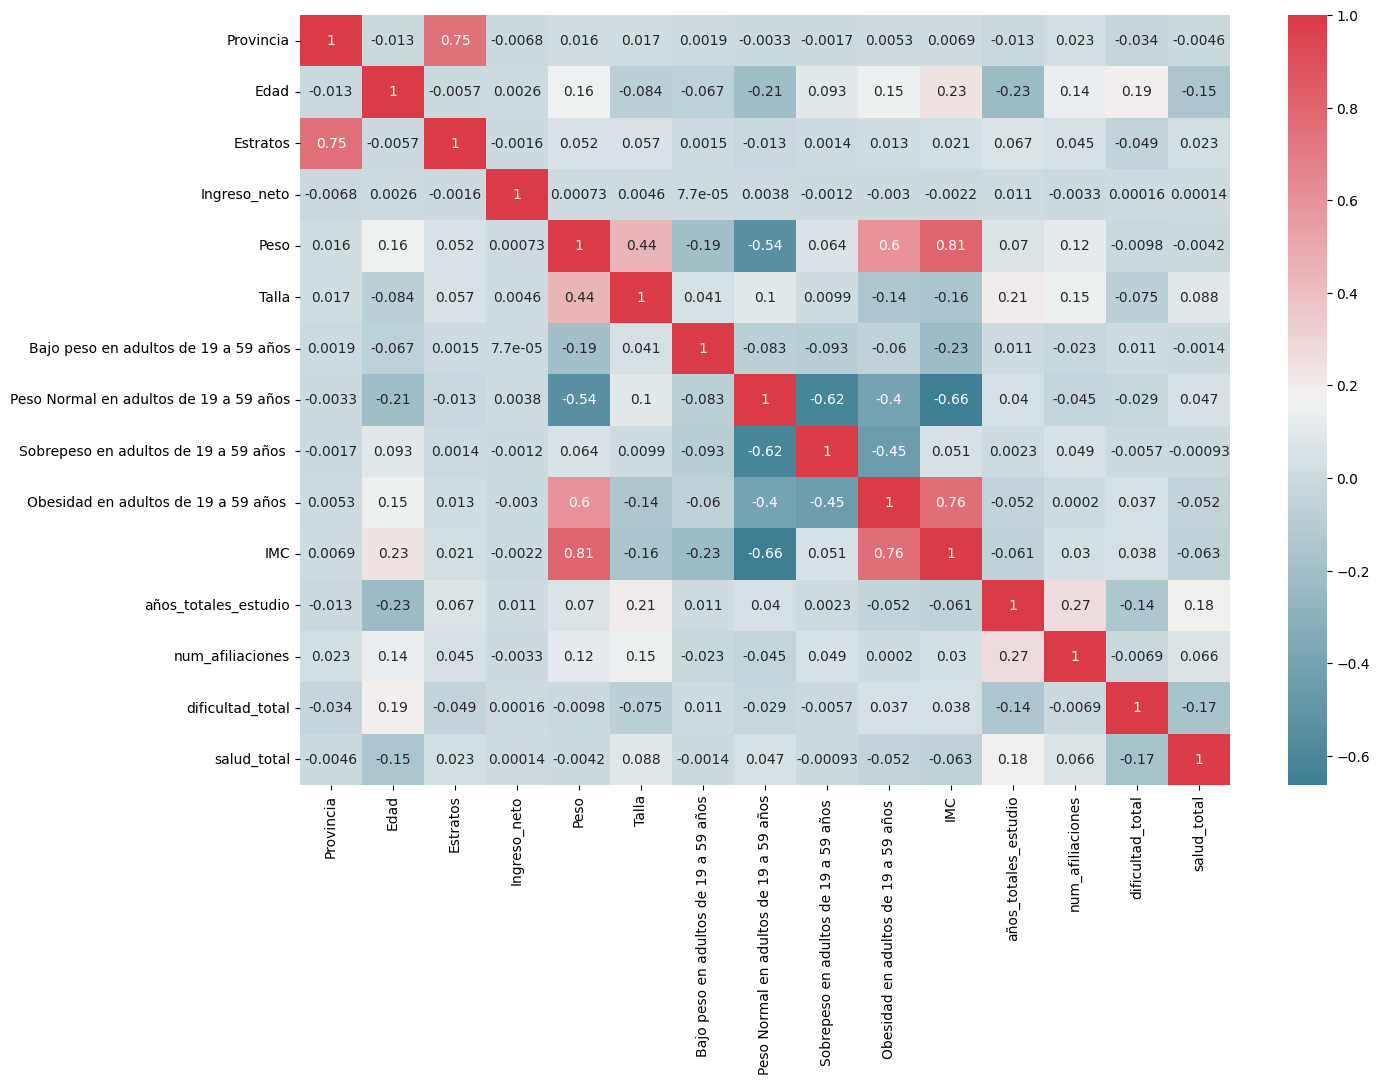

In [ ]:
correlation_heatmap(df.select_dtypes(include=['number']))

In [ ]:
round(df.select_dtypes(include=['number']).corr(),4)

Provincia    Edad  Estratos  Ingreso_neto    Peso   Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años      IMC  años_totales_estudio  num_afiliaciones  dificultad_total  salud_total
Provincia                                  1.0000 -0.0128    0.7524       -0.0068  0.0163  0.0172                                0.0019                                 -0.0033                                -0.0017                                0.0053  0.0069               -0.0127            0.0229           -0.0339      -0.0046
Edad                                      -0.0128  1.0000   -0.0057        0.0026  0.1607 -0.0844                               -0.0669                                 -0.2138                                 0.0927                                0.1539  0.2337               -0.2327            0.1406            0.1867      -0.1509
Estratos                                   0.7524 -0.0057    1.0000       -0.0016  0.0520  0.0575                                0.0015                                 -0.0134                                 0.0014                                0.0134  0.0208                0.0675            0.0447           -0.0486       0.0227
Ingreso_neto                              -0.0068  0.0026   -0.0016        1.0000  0.0007  0.0046                                0.0001                                  0.0038                                -0.0012                               -0.0030 -0.0022                0.0111           -0.0033            0.0002       0.0001
Peso                                       0.0163  0.1607    0.0520        0.0007  1.0000  0.4433                               -0.1909                                 -0.5446                                 0.0638                                0.6010  0.8064                0.0702            0.1162           -0.0098      -0.0042
Talla                                      0.0172 -0.0844    0.0575        0.0046  0.4433  1.0000                                0.0406                                  0.1015                                 0.0099                               -0.1391 -0.1623                0.2070            0.1474           -0.0749       0.0883
Bajo peso en adultos de 19 a 59 años       0.0019 -0.0669    0.0015        0.0001 -0.1909  0.0406                                1.0000                                 -0.0829                                -0.0933                               -0.0600 -0.2270                0.0111           -0.0230            0.0109      -0.0014
Peso Normal en adultos de 19 a 59 años    -0.0033 -0.2138   -0.0134        0.0038 -0.5446  0.1015                               -0.0829                                  1.0000                                -0.6177                               -0.3972 -0.6628                0.0403           -0.0450           -0.0287       0.0467
Sobrepeso en adultos de 19 a 59 años      -0.0017  0.0927    0.0014       -0.0012  0.0638  0.0099                               -0.0933                                 -0.6177                                 1.0000                               -0.4468  0.0508                0.0023            0.0488           -0.0057      -0.0009
Obesidad en adultos de 19 a 59 años        0.0053  0.1539    0.0134       -0.0030  0.6010 -0.1391                               -0.0600                                 -0.3972                                -0.4468                                1.0000  0.7616               -0.0520            0.0002            0.0368      -0.0522
IMC                                        0.0069  0.2337    0.0208       -0.0022  0.8064 -0.1623                               -0.2270                                 -0.6628                                 0.0508                                0.7616  1.0000               -0.0607            0.0303            0.0375      -0.0633
años_totales_estudio                      -0.0127 -0.232

### **Codificación de columnas categóricas**

In [ ]:
see_unique_values()

Área: ['urbano' 'rural']

Sexo: ['hombre' 'mujer']

Parentesco con el jefe (a) de hogar: ['jefe/a de hogar' 'cónyuge' 'hijo/a' 'yerno / nuera' 'padres / suegros'
 'otros parientes' 'nieto / nieta' 'otros no parientes' 'empleada/o dom']

Cuál es su Estado Civil ó Conyugal: ['unión libre' 'soltero' 'casado' 'separado' 'divorciado' 'viudo'
 'unión de hecho']

Identificación étnica: ['Mestizo' 'Blanco' 'Indígena' 'Afro-ecuatoriano' 'Montubio u Otros']

Sabe leer y escribir: ['si' 'no']

Por los estudios realizados obtuvo algún título superior: ['no' 'si']

Principalmente donde acude o acudiría para tratar sus problemas de salud: ['medicina general(convencional)' 'homeopatía' 'acupuntura'
 'curanderos/shamán/partera/limpiador' 'fitoterapia'
 'otro, cuál especificar']

Asiste, actualmente a clases: ['no' 'si']

Cuántos trabajos tuvo, en la semana pasada: ['uno' 'cero' 'más de uno']

Qué hizo la semana pasada: ['trabajó al menos una hora' 'no trabajó']

Además de su ingreso monetario ,recibió

In [ ]:
df.head(5)

Área  Provincia    Sexo  Edad Parentesco con el jefe (a) de hogar Cuál es su Estado Civil ó Conyugal Identificación étnica  Estratos Sabe leer y escribir Por los estudios realizados obtuvo algún título superior Principalmente donde acude o acudiría para tratar sus problemas de salud Asiste, actualmente a clases Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc. Recibe el Bono de desarrollo humano En el lugar indicado, trabaja o trabajó como  Ingreso_neto Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años         IMC  años_totales_estudio  num_afiliaciones  dificultad_total  salud_total
0   urbano          1  hombre    28                     jefe/a de hogar                        unión libre               Mestizo      2713                   si                                                 no                           medicina general(convencional)                                                 no                                        uno  trabajó al menos una hora                                                 no                                                                                                          no                empleado(a)/obrero(a) privado         440.0                                   no   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0  27.111653                   6.0                 1                 0            4
6   urbano          1   mujer    36                     jefe/a de hogar                        unión libre               Mestizo      2713                   si                                                 no                           medicina general(convencional)                                                 no                                        uno  trabajó al menos una hora                                                 no                                                                                                          no                                cuenta propia         300.0                                   no   75.800003  157.70000                                   0.0                                     0.0                                    0.0                                   1.0  30.479359                  11.0                 0                 0            4
7   urbano          1  hombre    30                             cónyuge                        unión libre               Mestizo      2713                   si                                                 no                           medicina general(convencional)                                                 no                                       cero  trabajó al menos una hora                                                 no                                                                                                          no       trabajador(a) del hogar  no remunerado          25.0                                   no  120.600000  173.30000                                   0.0                                     0.0                                    0.0                                   1.0  40.155976                  11.0                 0                 0            5
8   urbano          1   mujer    19                              hijo/a                        unión libre               Mestizo      2713                   si                                                 no                           medicina general(convencional)                                                 no                                       cero  trabajó al menos una hora  

In [ ]:
binary_dict = {
    'si': 1,
    'no': 0,
    'hombre': 1,
    'mujer': 0,
    'urbano': 1,
    'rural': 0
}

binary_cols = ['Área','Sexo','Sabe leer y escribir', "Por los estudios realizados obtuvo algún título superior", "Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.",
               "Asiste, actualmente a clases", 'Tuvo algún parto  _últimos 12 meses ', 'Recibe el Bono de desarrollo humano']

df[binary_cols] = df[binary_cols].replace(binary_dict)
df["Qué hizo la semana pasada"] = df["Qué hizo la semana pasada"].replace({'trabajó al menos una hora':1, 'no trabajó':0})
df["Cuántos trabajos tuvo, en la semana pasada"] = df["Cuántos trabajos tuvo, en la semana pasada"].replace({"cero":0, "uno":1, "más de uno":2})


In [ ]:
see_unique_values()

Parentesco con el jefe (a) de hogar: ['jefe/a de hogar' 'cónyuge' 'hijo/a' 'yerno / nuera' 'padres / suegros'
 'otros parientes' 'nieto / nieta' 'otros no parientes' 'empleada/o dom']

Cuál es su Estado Civil ó Conyugal: ['unión libre' 'soltero' 'casado' 'separado' 'divorciado' 'viudo'
 'unión de hecho']

Identificación étnica: ['Mestizo' 'Blanco' 'Indígena' 'Afro-ecuatoriano' 'Montubio u Otros']

Principalmente donde acude o acudiría para tratar sus problemas de salud: ['medicina general(convencional)' 'homeopatía' 'acupuntura'
 'curanderos/shamán/partera/limpiador' 'fitoterapia'
 'otro, cuál especificar']

En el lugar indicado, trabaja o trabajó como: ['empleado(a)/obrero(a) privado' 'cuenta propia'
 'trabajador(a) del hogar  no remunerado' 'no trabaja' 'patrono(a)'
 'empleado(a)/obrero(a) de gobierno/estado'
 'trabajador(a) no remunerado  en otro hogar' 'jornalero(a) o peón'
 'empleado(a) doméstico(a)']



In [ ]:
alta_cardinalidad, baja_cardinalidad = determinar_cardinalidad(df)
print(alta_cardinalidad)
print('')
print(baja_cardinalidad)

['Parentesco con el jefe (a) de hogar', 'Cuál es su Estado Civil ó Conyugal', 'Principalmente donde acude o acudiría para tratar sus problemas de salud', 'En el lugar indicado, trabaja o trabajó como']

['Identificación étnica']


In [ ]:
df=create_dummies(df,baja_cardinalidad)

encoder = ce.BinaryEncoder(cols=alta_cardinalidad)
df_binary_coded = encoder.fit_transform(df[alta_cardinalidad])
df=pd.concat([df,df_binary_coded],axis=1)

In [ ]:
df.columns

Index(['Área', 'Provincia', 'Sexo', 'Edad',
       'Parentesco con el jefe (a) de hogar',
       'Cuál es su Estado Civil ó Conyugal', 'Identificación étnica',
       'Estratos', 'Sabe leer y escribir',
       'Por los estudios realizados obtuvo algún título superior',
       'Principalmente donde acude o acudiría para tratar sus problemas de salud',
       'Asiste, actualmente a clases',
       'Cuántos trabajos tuvo, en la semana pasada',
       'Qué hizo la semana pasada',
       'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
       'Recibe el Bono de desarrollo humano',
       'En el lugar indicado, trabaja o trabajó como', 'Ingreso_neto',
       'Tuvo algún parto  _últimos 12 meses ', 'Peso', 'Talla',
       'Bajo peso en adultos de 19 a 59 años',
       'Peso Normal en adultos de 19 a 59 años',
       'Sobrepeso en adultos de 19 a 59 años ',
       'Obesidad en adultos de 19 a 59 años ', 'IMC', 'años_t

In [ ]:
eliminar_columnas_cat(df)

In [ ]:
boolean_columns = df.select_dtypes(include='bool').columns

df[boolean_columns] = df[boolean_columns].astype(int)

In [ ]:
df.head(5)

Área  Provincia  Sexo  Edad  Estratos  Sabe leer y escribir  Por los estudios realizados obtuvo algún título superior  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años         IMC  años_totales_estudio  num_afiliaciones  dificultad_total  salud_total  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3
0      1          1     1    28      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0  27.111653                   6.0                 1                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                                           0                                                                           1                                                                        0                                               0                                               0                                               1
6      1          1     0    36      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         300.0                                     0   75.800003  157.70000                                   0.0                                     0.0                                    0.0                                   1.0  30.479359                  11.0                 0                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                

In [ ]:
df.dtypes

Área                                                                                                                            int64
Provincia                                                                                                                       int64
Sexo                                                                                                                            int64
Edad                                                                                                                            int64
Estratos                                                                                                                        int64
Sabe leer y escribir                                                                                                            int64
Por los estudios realizados obtuvo algún título superior                                                                        int64
Asiste, actualmente a clases                                  

In [ ]:
df.shape

(74786, 44)

array([[<Axes: title={'center': 'Área'}>,
        <Axes: title={'center': 'Provincia'}>,
        <Axes: title={'center': 'Sexo'}>,
        <Axes: title={'center': 'Edad'}>,
        <Axes: title={'center': 'Estratos'}>,
        <Axes: title={'center': 'Sabe leer y escribir'}>,
        <Axes: title={'center': 'Por los estudios realizados obtuvo algún título superior'}>],
       [<Axes: title={'center': 'Asiste, actualmente a clases'}>,
        <Axes: title={'center': 'Cuántos trabajos tuvo, en la semana pasada'}>,
        <Axes: title={'center': 'Qué hizo la semana pasada'}>,
        <Axes: title={'center': 'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.'}>,
        <Axes: title={'center': 'Recibe el Bono de desarrollo humano'}>,
        <Axes: title={'center': 'Ingreso_neto'}>,
        <Axes: title={'center': 'Tuvo algún parto  _últimos 12 meses '}>],
       [<Axes: title={'center': 'Peso'}>,
        <Axes: titl

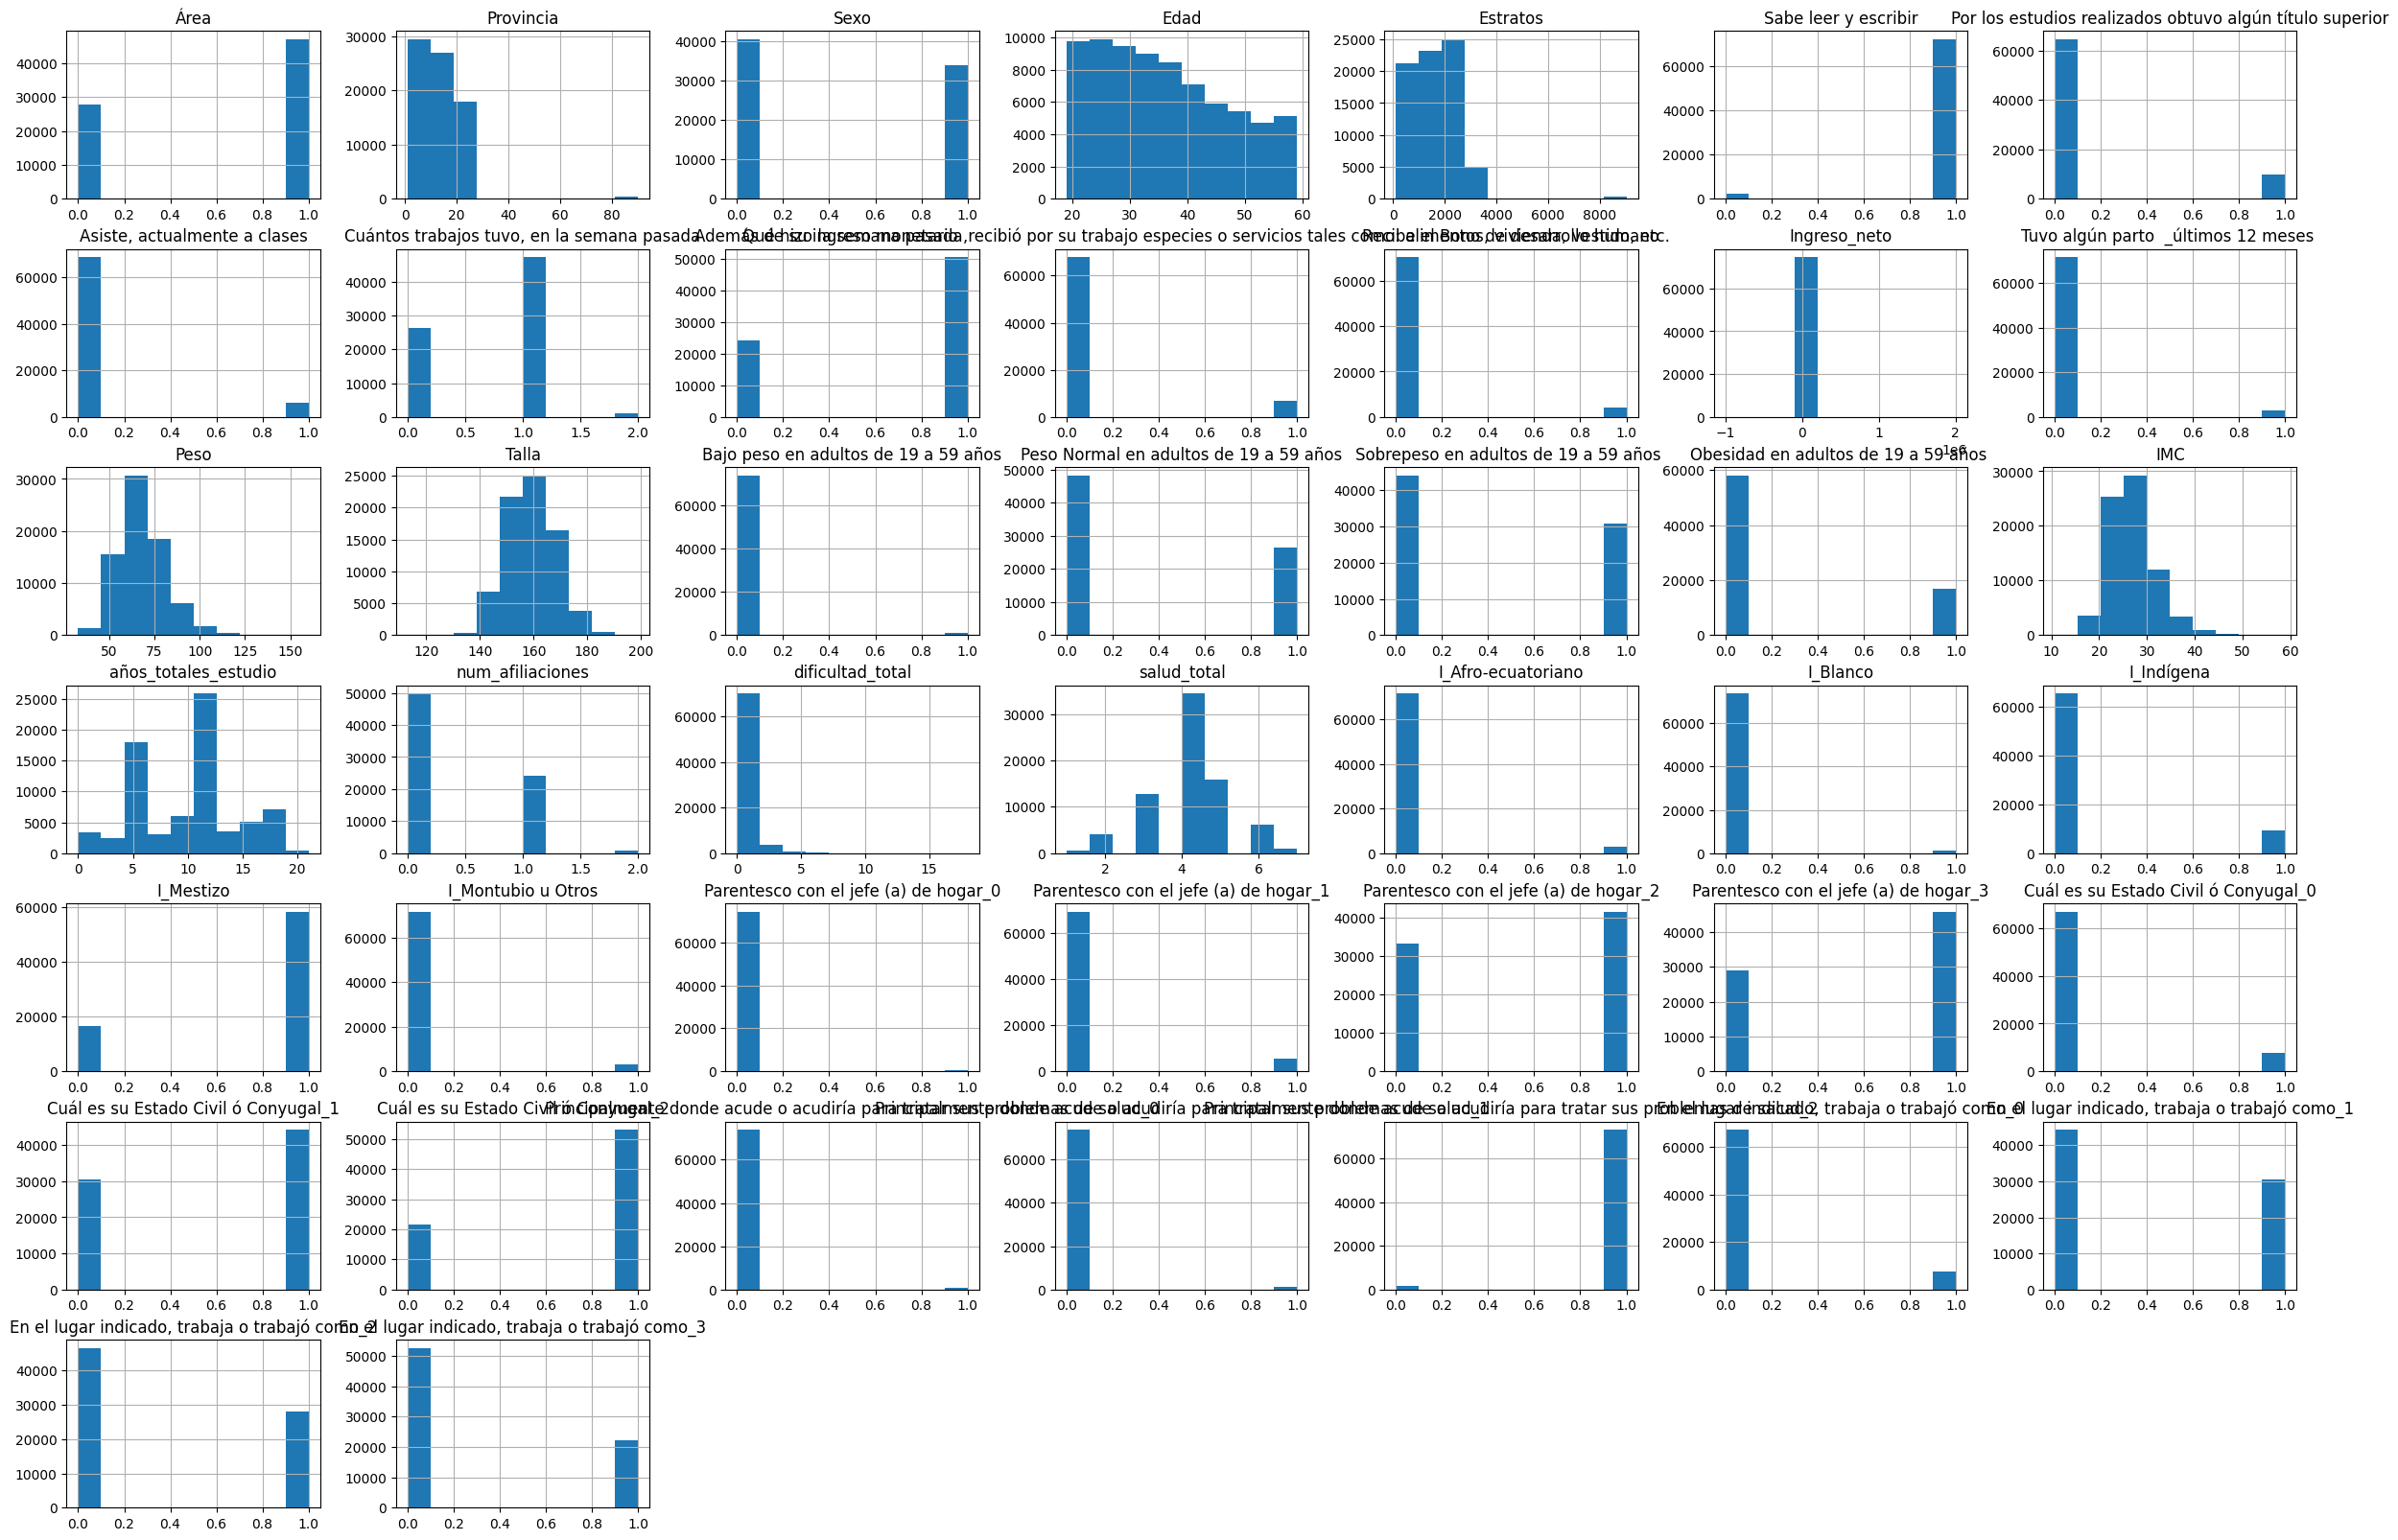

In [ ]:
df.hist(figsize=(30,20))

In [ ]:
df.reset_index(drop=True, inplace=True)
df.head(5)

Área  Provincia  Sexo  Edad  Estratos  Sabe leer y escribir  Por los estudios realizados obtuvo algún título superior  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años         IMC  años_totales_estudio  num_afiliaciones  dificultad_total  salud_total  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3
0     1          1     1    28      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0  27.111653                   6.0                 1                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                                           0                                                                           1                                                                        0                                               0                                               0                                               1
1     1          1     0    36      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         300.0                                     0   75.800003  157.70000                                   0.0                                     0.0                                    0.0                                   1.0  30.479359                  11.0                 0                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  

### **Creacion de columna objetivo (Weight Category)**

In [ ]:
df['weight_category'] = df.apply(map_weight_category, axis=1)

In [ ]:
df.head(5)

Área  Provincia  Sexo  Edad  Estratos  Sabe leer y escribir  Por los estudios realizados obtuvo algún título superior  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años         IMC  años_totales_estudio  num_afiliaciones  dificultad_total  salud_total  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3  weight_category
0     1          1     1    28      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0  27.111653                   6.0                 1                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                                           0                                                                           1                                                                        0                                               0                                               0                                               1                2
1     1          1     0    36      2713                     1                                                  0                                    0                                           1                          1                                                  0                                                                                                             0         300.0                                     0   75.800003  157.70000                                   0.0                                     0.0                                    0.0                                   1.0  30.479359                  11.0                 0                 0            4                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                

In [ ]:
df.drop(columns=['Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años '], axis=1, inplace=True)

df.columns

Index(['Área', 'Provincia', 'Sexo', 'Edad', 'Estratos', 'Sabe leer y escribir',
       'Por los estudios realizados obtuvo algún título superior',
       'Asiste, actualmente a clases',
       'Cuántos trabajos tuvo, en la semana pasada',
       'Qué hizo la semana pasada',
       'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
       'Recibe el Bono de desarrollo humano', 'Ingreso_neto',
       'Tuvo algún parto  _últimos 12 meses ', 'Peso', 'Talla', 'IMC',
       'años_totales_estudio', 'num_afiliaciones', 'dificultad_total',
       'salud_total', 'I_Afro-ecuatoriano', 'I_Blanco', 'I_Indígena',
       'I_Mestizo', 'I_Montubio u Otros',
       'Parentesco con el jefe (a) de hogar_0',
       'Parentesco con el jefe (a) de hogar_1',
       'Parentesco con el jefe (a) de hogar_2',
       'Parentesco con el jefe (a) de hogar_3',
       'Cuál es su Estado Civil ó Conyugal_0',
       'Cuál es su Estado Civil ó Con

### **Creación de matriz de características (X) y variable objetivo (y)**

####**Creación de un dataframe (df_LR) para aplicar regresión lineal**  
En este dataframe, se ha establecido el IMC como la variable objetivo (y), la cual es un dato numérico continuo. Para la creación de este dataframe, se han eliminado las columnas correspondientes a peso y talla, ya que el objetivo es predecir el IMC en función de las características sociodemográficas de los individuos. Adicionalmente, se ha procedido a eliminar las primeras columnas generadas a partir de las variables dummies. Esta acción se realiza con el fin de evitar problemas de colinealidad en el modelo de regresión lineal y, simultáneamente, reducir la dimensionalidad del conjunto de datos.


In [ ]:
# Crear el nuevo dataset df_LR excluyendo las columnas 'Peso', 'Talla' y 'weight_category'
df_LR = df.drop(columns=['Peso', 'Talla', 'weight_category'])

# Separar en X (características) e y (objetivo)
X = df_LR.drop(columns=['IMC'])  # Excluye la columna 'IMC' para X
y = df_LR['IMC']  # La columna 'IMC' es el objetivo

# Identificar las columnas dummy y eliminar una para evitar colinearidad
dummy_columns = [col for col in X.columns if '_0' in col]
X = X.drop(columns=dummy_columns)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar las primeras filas de los nuevos datasets escalados
print(X_train[:5])
print(y_train.head())

[[ 7.66447926e-01  4.54792802e-01  1.09230849e+00  7.54502723e-01
   9.45856553e-01  1.75799265e-01 -3.92403211e-01 -2.99311291e-01
   6.71943997e-01  6.91004921e-01 -3.19701818e-01 -2.46961474e-01
   9.56079736e-03 -2.08406744e-01 -9.62497929e-01  1.32046065e+00
  -3.12456446e-01 -1.07093716e-01 -2.07321635e-01 -1.23079794e-01
  -3.75737441e-01  5.31997002e-01 -2.06090782e-01 -2.80361813e-01
  -1.11961630e+00  7.95113187e-01  8.30112425e-01  6.39144232e-01
  -1.19389055e-01  1.53656786e-01 -8.29721853e-01 -7.77410951e-01
   1.54109435e+00]
 [ 7.66447926e-01 -5.67846422e-03  1.09230849e+00 -8.60125716e-01
  -2.85331567e-01  1.75799265e-01 -3.92403211e-01  3.34100326e+00
   6.71943997e-01  6.91004921e-01 -3.19701818e-01 -2.46961474e-01
   4.03682585e-03 -2.08406744e-01  1.34306023e+00 -6.92790254e-01
  -3.12456446e-01 -1.07093716e-01 -2.07321635e-01 -1.23079794e-01
  -3.75737441e-01  5.31997002e-01 -2.06090782e-01 -2.80361813e-01
   8.93163134e-01  7.95113187e-01 -1.20465610e+00  6.3914

### **Escalado**

### **Selección de características**

In [ ]:
# Calcular la información mutua
mi_score = mutual_info_regression(X_scaled, y)

# Crear un dataframe para mostrar los resultados
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_score})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Mostrar las características ordenadas por información mutua
print(mi_df)

                                              Feature  Mutual Information
2                                                Sexo            0.066385
3                                                Edad            0.051170
4                                            Estratos            0.023646
1                                           Provincia            0.022331
25              Parentesco con el jefe (a) de hogar_3            0.022086
24              Parentesco con el jefe (a) de hogar_2            0.020722
8          Cuántos trabajos tuvo, en la semana pasada            0.017183
9                           Qué hizo la semana pasada            0.011803
27               Cuál es su Estado Civil ó Conyugal_2            0.011527
14                               años_totales_estudio            0.010969
12                                       Ingreso_neto            0.010394
20                                         I_Indígena            0.009915
7                        Asiste, actua

# **Aprendizaje automático**

##**Regresión Lineal para predecir el IMC**

###**Regresión lineal con todas las características escaladas**

In [ ]:
#Regresión lineal con todas las características del dataset

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
r2_score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {r2_score}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


R^2 score: 0.0896958267897996
MAE: 3.4486235124250983
MSE: 20.925365213931165


###**Regresión lineal con las características seleccionadas de mutual info regression**

In [ ]:
# Selección de un umbral de información mutua (por ejemplo, 0.01)
threshold = 0.01
relevant_features = mi_df[mi_df['Mutual Information'] > threshold]['Feature']

# Crear un nuevo conjunto de datos con solo las características relevantes
X_relevant = X[relevant_features]

# Escalar las características
scaler = StandardScaler()
X_relevant_scaled = scaler.fit_transform(X_relevant)

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_relevant_scaled, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
score = model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score: {score}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")


R^2 score: 0.07207592166927324
MAE: 3.4826431680794303
MSE: 21.330397905785794


###**Regresión lineal con características relevantes seleccionadas y con selección automática de parámetros**

In [ ]:

# Crear un pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Definir el espacio de parámetros para GridSearchCV
param_grid = [
    {
        'poly__degree': [1, 2, 3],  # Reducido el rango de grados
        'regressor': [LinearRegression()]
    },
    {
        'poly__degree': [1, 2, 3],  # Reducido el rango de grados
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Reducido el número de alphas
    },
    {
        'poly__degree': [1, 2, 3],  # Reducido el rango de grados
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 10.0]  # Reducido el número de alphas
    }
]


# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_relevant_scaled, y, test_size=0.2, random_state=42)

# Entrenar RandomizedSearchCV
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor R^2 score en entrenamiento: {best_score}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

test_score = best_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2 score en el conjunto de prueba: {test_score}")
print(f"MAE en el conjunto de prueba: {mae}")
print(f"MSE en el conjunto de prueba: {mse}")


Mejores parámetros: {'regressor__alpha': 10.0, 'regressor': Ridge(alpha=10.0), 'poly__degree': 2}
Mejor R^2 score en entrenamiento: 0.0951499215827339
R^2 score en el conjunto de prueba: 0.08863634050321667
MAE en el conjunto de prueba: 3.445126032104986
MSE en el conjunto de prueba: 20.949719861683374


## **Árbol de Decisión**

###**Árbol de Decisión sin oversampling**

In [ ]:
# Creación de un nuevo dataframe (diferente al de regresión lineal)
df_DT = df.drop(columns=['Peso', 'Talla', 'IMC'])

# Separar en X (características) e y (objetivo)
X = df_DT.drop(columns=['weight_category'])
y = df_DT['weight_category']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
# Crear el modelo de árbol de decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_score = best_model.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_score}")

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)


Mejores parámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mejor accuracy en entrenamiento: 0.4618907895123205
Accuracy en el conjunto de prueba: 0.4581494852252975
Accuracy: 0.4581494852252975
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      0.47      0.48      5287
           2       0.45      0.64      0.52      6132
           3       0.40      0.14      0.21      3339

    accuracy                           0.46     14958
   macro avg       0.33      0.31      0.30     14958
weighted avg       0.45      0.46      0.43     14958

Confusion Matrix:
 [[   0  115   78    7]
 [   1 2475 2564  247]
 [   1 1760 3912  459]
 [   0  640 2233  466]]


####**Visualización de las métricas**

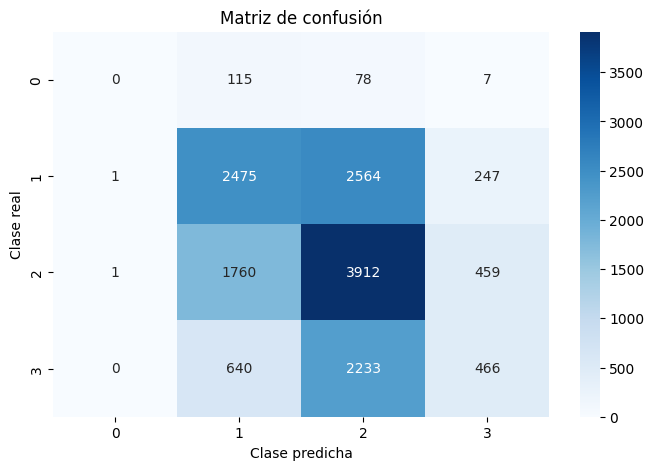

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()


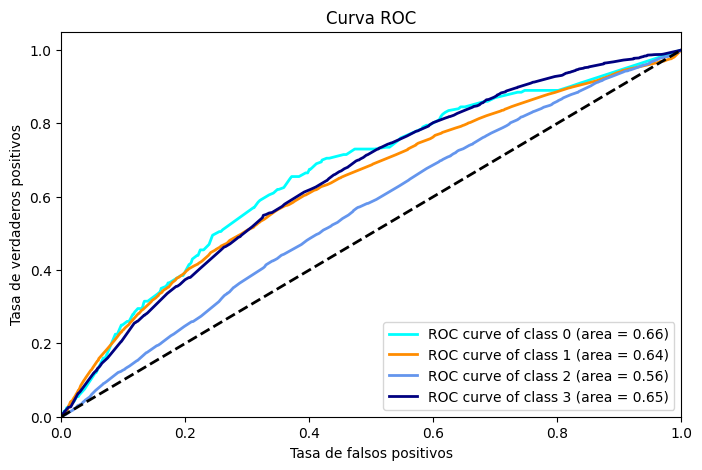

In [ ]:
# Visualización de la curva ROC
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

###**Árbol de decisión con sobremuestreo (oversampling)**

####**Con RandomOverSampler**

In [ ]:
# Aplicar RandomOverSampler para balancear las clases en el conjunto de entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el modelo de árbol de decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Entrenar GridSearchCV con el dataset balanceado
grid_search.fit(X_train_res, y_train_res)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_score = best_model.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_score}")

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor accuracy en entrenamiento: 0.6791078354826791
Accuracy en el conjunto de prueba: 0.3807995721353122
Accuracy: 0.3807995721353122
Classification Report:
               precision    recall  f1-score   support

           0       0.02      0.01      0.02       200
           1       0.41      0.41      0.41      5287
           2       0.42      0.41      0.42      6132
           3       0.29      0.30      0.30      3339

    accuracy                           0.38     14958
   macro avg       0.28      0.28      0.28     14958
weighted avg       0.38      0.38      0.38     14958

Confusion Matrix:
 [[   3   92   72   33]
 [  97 2149 2045  996]
 [  63 2108 2536 1425]
 [  34  930 1367 1008]]


#####**Visualización de las métricas**

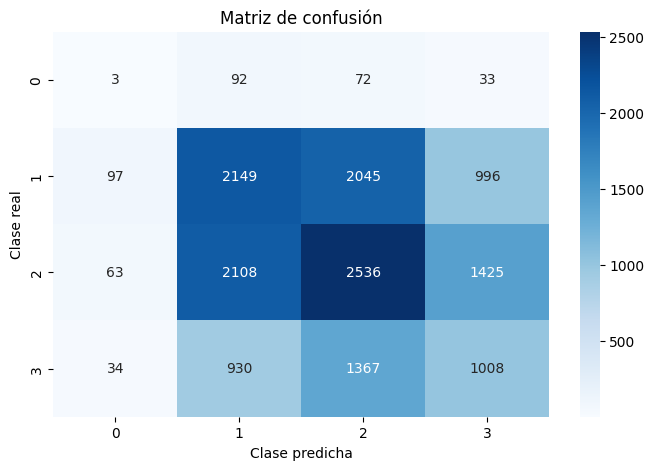

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

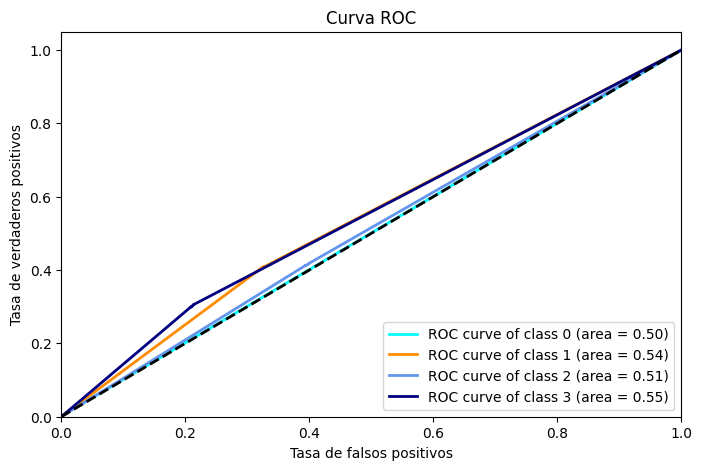

In [ ]:
# Visualización de la curva ROC
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

####**Árbol de decisión con sobremuestreo (oversampling) utilizando SMOTE (Synthetic Minority Over-sampling Technique)**

In [ ]:
# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el modelo de árbol de decisión
dt_model = DecisionTreeClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Entrenar GridSearchCV con el dataset balanceado
grid_search.fit(X_train_res, y_train_res)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

test_score = best_model.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_score}")

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)


Mejores parámetros: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor accuracy en entrenamiento: 0.5473504344081415
Accuracy en el conjunto de prueba: 0.37484957882069797
Accuracy: 0.37484957882069797
Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.05      0.04       200
           1       0.41      0.40      0.41      5287
           2       0.42      0.39      0.41      6132
           3       0.29      0.32      0.30      3339

    accuracy                           0.37     14958
   macro avg       0.29      0.29      0.29     14958
weighted avg       0.38      0.37      0.38     14958

Confusion Matrix:
 [[  10   83   68   39]
 [ 147 2125 1923 1092]
 [ 129 2069 2415 1519]
 [  61  889 1332 1057]]


#####**Visualización de las métricas**

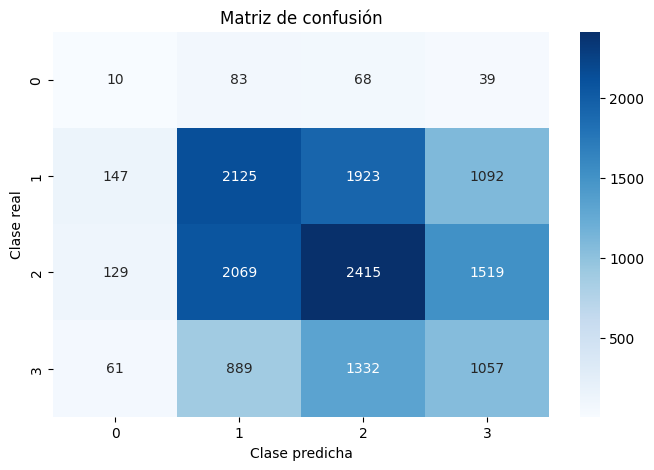

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

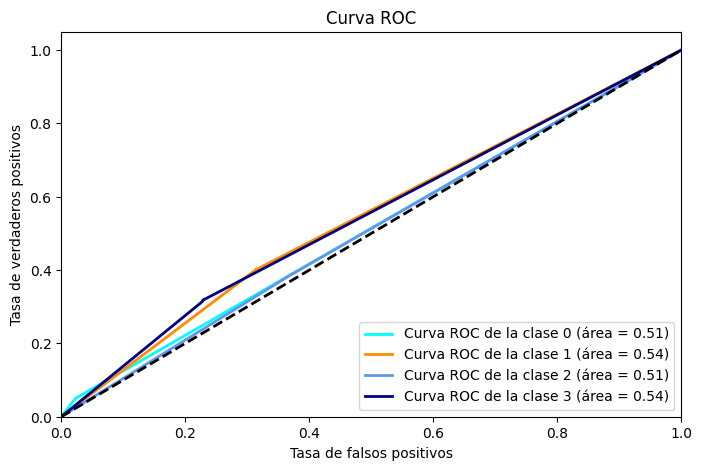

In [ ]:
# Curva ROC para problemas multiclase
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## **Random Forest**

###**Sin PCA**

In [ ]:
# Tomar un subconjunto del conjunto de entrenamiento
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

# Aplicar SMote al subconjunto
smote = SMOTE(random_state=42)
X_train_sub_res, y_train_sub_res = smote.fit_resample(X_train_sub, y_train_sub)

# Definir el espacio de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Entrenar RandomizedSearchCV con el subconjunto del dataset balanceado
random_search.fit(X_train_sub_res, y_train_sub_res)

# Obtener los mejores parámetros
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")

# Entrenar el modelo con los mejores parámetros encontrados en el conjunto de entrenamiento completo
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_res, y_train_res)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

test_score = best_model.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_score}")

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Mejor accuracy en entrenamiento: 0.6215830273357813


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy en el conjunto de prueba: 0.42124615590319564
Accuracy: 0.42124615590319564
Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.01      0.02       200
           1       0.45      0.46      0.46      5287
           2       0.43      0.48      0.46      6132
           3       0.33      0.28      0.30      3339

    accuracy                           0.42     14958
   macro avg       0.31      0.31      0.31     14958
weighted avg       0.41      0.42      0.42     14958

Confusion Matrix:
 [[   2  107   70   21]
 [  32 2410 2167  678]
 [  22 1994 2963 1153]
 [  10  791 1612  926]]


####**Visualización de las métricas**

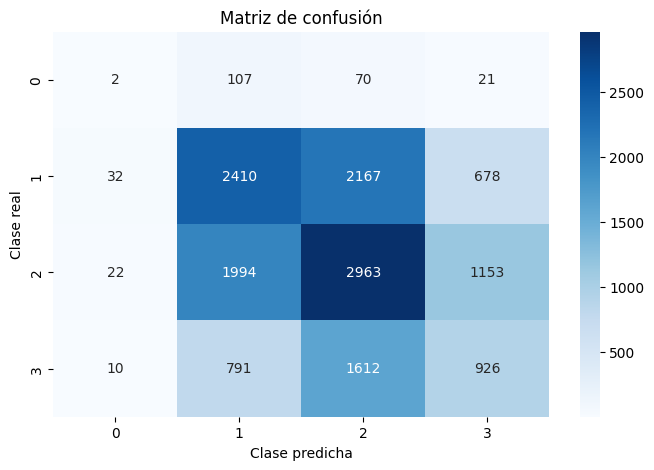

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

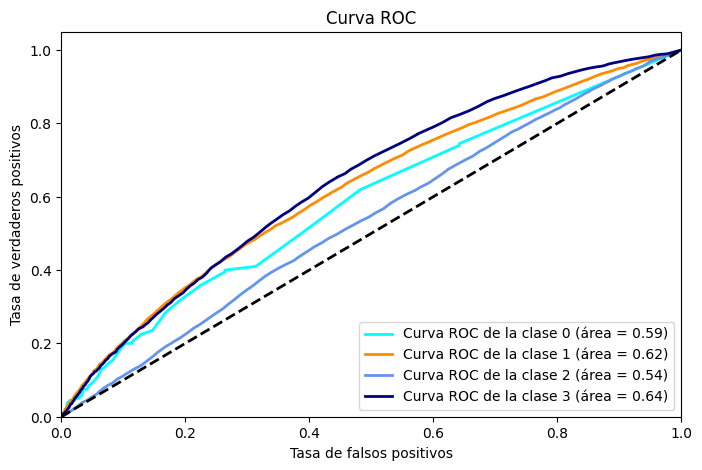

In [ ]:
# Curva ROC para problemas multiclase
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

###**Con PCA**

In [ ]:
# Tomar un subconjunto del conjunto de entrenamiento
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

# Aplicar SMOTE al subconjunto
smote = SMOTE(random_state=42)
X_train_sub_res, y_train_sub_res = smote.fit_resample(X_train_sub, y_train_sub)

# Aplicar PCA para reducir la dimensionalidad en el subconjunto
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_train_sub_res_pca = pca.fit_transform(X_train_sub_res)
X_test_pca = pca.transform(X_test)

# Definir el espacio de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Entrenar RandomizedSearchCV con el subconjunto del dataset balanceado y reducido por PCA
random_search.fit(X_train_sub_res_pca, y_train_sub_res)

# Obtener los mejores parámetros
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")

# Aplicar SMOTE al conjunto de entrenamiento completo
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Aplicar PCA al conjunto de entrenamiento completo
X_train_res_pca = pca.fit_transform(X_train_res)

# Entrenar el modelo con los mejores parámetros encontrados en el conjunto de entrenamiento completo
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_res_pca, y_train_res)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_model.predict(X_test_pca)

test_score = best_model.score(X_test_pca, y_test)
print(f"Accuracy en el conjunto de prueba: {test_score}")

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Mejor accuracy en entrenamiento: 0.4456854345165239
Accuracy en el conjunto de prueba: 0.21573739804786737
Accuracy: 0.21573739804786737
Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.41      0.03       200
           1       0.35      0.15      0.21      5287
           2       0.41      0.30      0.34      6132
           3       0.22      0.17      0.19      3339

    accuracy                           0.22     14958
   macro avg       0.25      0.25      0.19     14958
weighted avg       0.34      0.22      0.26     14958

Confusion Matrix:
 [[  82   25   64   29]
 [2109  773 1492  913]
 [2355  893 1809 1075]
 [1249  518 1009  563]]


####**Visualización de las métricas**

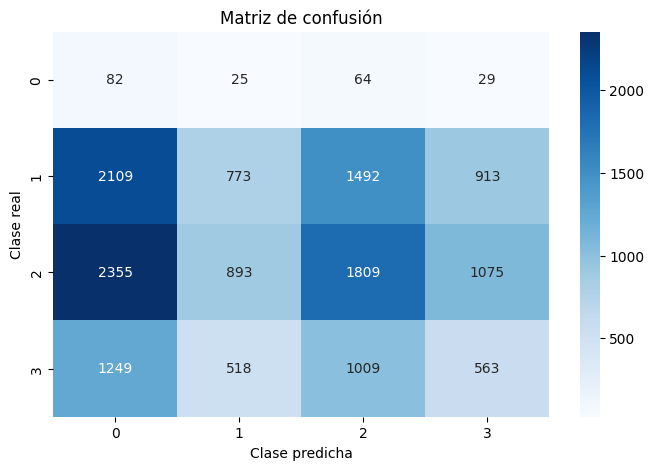

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

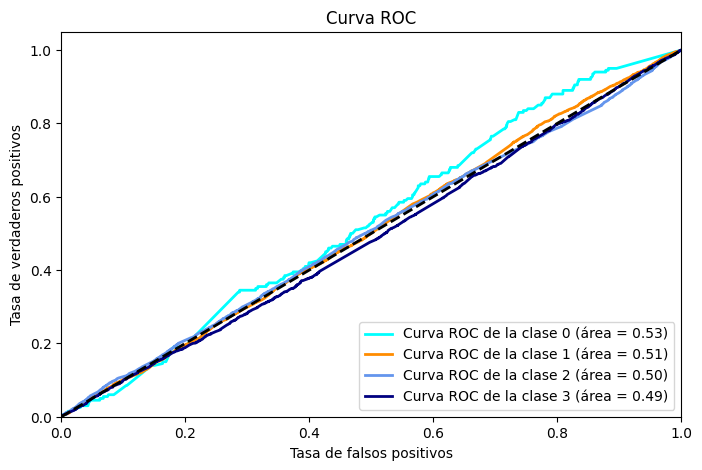

In [ ]:
# Curva ROC para problemas multiclase
y_test_bin = label_binarize(y_test, classes=best_model.classes_)
y_pred_prob = best_model.predict_proba(X_test_pca)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

##**XGBoost**

In [ ]:
# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento para balancear las clases
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Tomar un subconjunto del conjunto de entrenamiento para la búsqueda de hiperparámetros
X_train_sub, _, y_train_sub, _ = train_test_split(X_train_res, y_train_res, train_size=0.5, random_state=42)

# Crear el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Definir los hiperparámetros para la búsqueda en grilla
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Entrenar RandomizedSearchCV con el subconjunto del dataset balanceado
random_search.fit(X_train_sub, y_train_sub)

# Obtener los mejores parámetros
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy en entrenamiento: {best_score}")


# Entrenar el modelo con los mejores parámetros encontrados en el conjunto de entrenamiento completo balanceado
best_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params, random_state=42)
best_xgb.fit(X_train_res, y_train_res)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_xgb.predict(X_test)

# Calcular métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy en el conjunto de prueba: {accuracy}")
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Mejores parámetros: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Mejor accuracy en entrenamiento: 0.5849572456131426
Accuracy en el conjunto de prueba: 0.45794892365289475
Classification Report:
               precision    recall  f1-score   support

           0       0.04      0.03      0.03       200
           1       0.51      0.46      0.48      5287
           2       0.46      0.54      0.49      6132
           3       0.39      0.34      0.36      3339

    accuracy                           0.46     14958
   macro avg       0.35      0.34      0.34     14958
weighted avg       0.46      0.46      0.45     14958

Confusion Matrix:
 [[   5  113   62   20]
 [  68 2426 2183  610]
 [  50 1658 3283 1141]
 [  17  542 1644 1136]]


###**Visualización de las métricas**

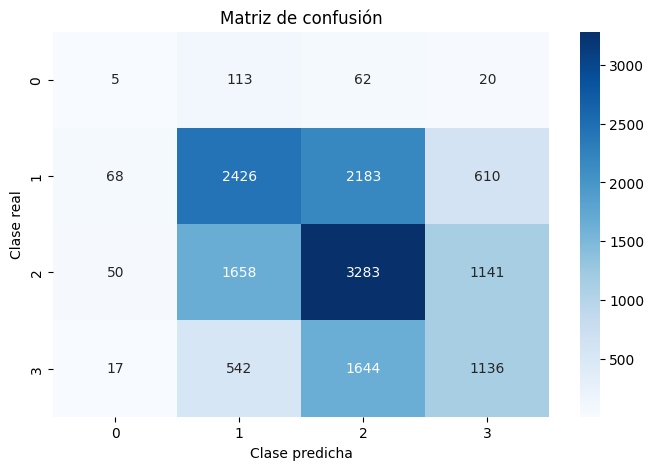

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_xgb.classes_, yticklabels=best_xgb.classes_)
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de confusión')
plt.show()

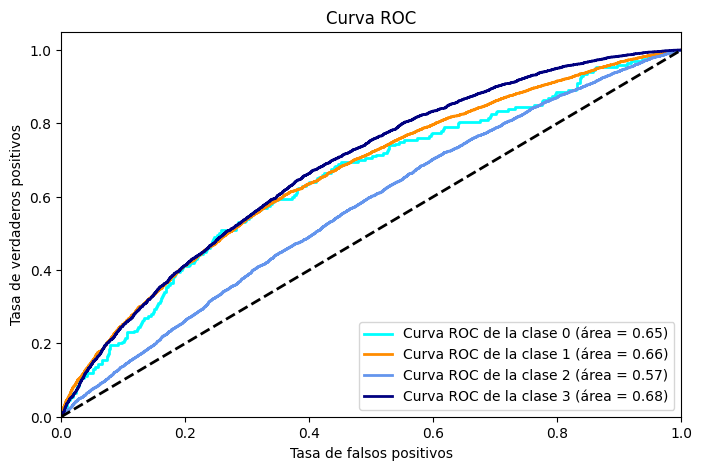

In [ ]:
# Curva ROC para problemas multiclase
y_test_bin = label_binarize(y_test, classes=best_xgb.classes_)
y_pred_prob = best_xgb.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 5))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()